### Alphatoe: Interpreting a one layer transformer that plays tic tac toe using techniques from mechanistic interpretability

### Imports - feel free to skip

In [7]:
import numpy as np
%load_ext autoreload
%autoreload 2
import torch
from alphatoe import plot, game, evals, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tqdm

import matplotlib.pyplot as plt
from importlib import reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Introduction

This project is about doing interpretability on a model that understands tic-tac-toe. We use a 1 layer 8 head transformer with a residual stream size of 128. Whenever we make a query of the model, we ask it in the following form: `[start_game_token, player1_move1, player2_move1, player1_move2, etc]`. The start_game_token is 10, and the potential moves are the ints 0 to 8. Here's an example game:

In [8]:
# Indices go from left to right, top to bottom
# 0 is the top left, 1 is top middle, etc.
# 10 is the start of game token, and 9 is the end of game token
example_game = [10, 0, 1, 2, 3, 4, 5, 6]
game.play_game(example_game)

| X | O | X |
| O | X | O |
| X |   |   |


Now let's load up the model and see what we're working with

In [9]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (ln2): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

Everything in this stage of the project is concerned with understanding how the model knows when to predict 9 (the end of game token). If we ask the model to predict the next token in our previous game, it should predict 9

In [10]:
# The last index of our logit is the end of game token, and we see it correctly predicts that!
logits = model(torch.tensor(example_game))
print(logits.shape)
print(logits[0, -1])

torch.Size([1, 8, 10])
tensor([-23.9999,   3.9674, -21.2261,   4.0562, -17.1209,   4.1609, -22.9341,
         13.0733,  13.2345,  26.3882], device='cuda:0',
       grad_fn=<SelectBackward0>)


Our model should never predict 10 (the start of game token), so the logits correspond to each possible tic tac toe move and the end of game token. i.e. {0...9}

We can see the predictions more clearly with a heatmap

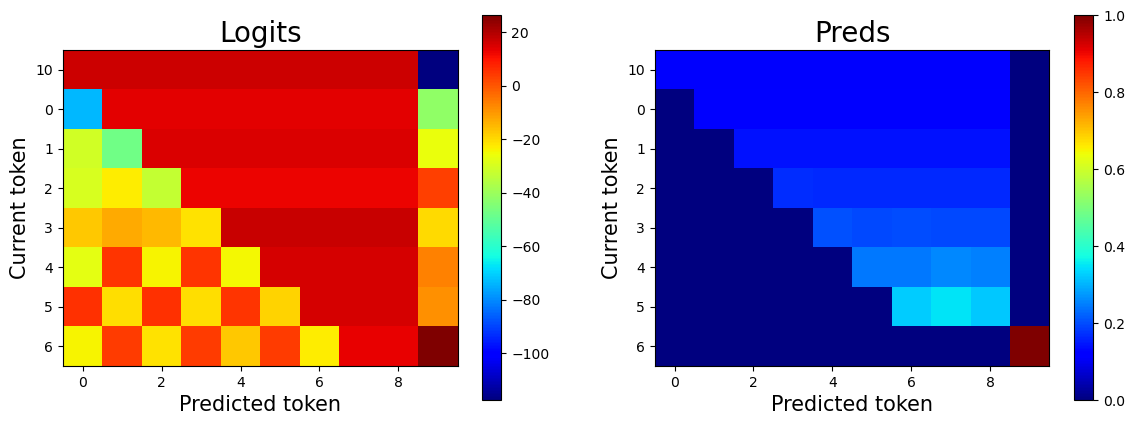

In [11]:
interpretability.plot_predictions(example_game, logits)

The two graphs are the raw logits, and the softmaxed logits. The x axis is the token our model predicts, and the y axis is the most recent token token. For example, in the preds graph, the value at current token = 5 and predicted token = 8 (abbreviated as (5,8)) is the probability the model assigns to token 8 being the correct next token when it is shown the sequence `[10, 0, 1, 2, 3, 4, 5]`, which in this case is ~.3. 

The model was trained to output a uniform probability distribution across the remaining possible moves, which is why we see a concentration of probabilites as the sequence length increases. 

Finally, notice how the value at (6,9) is ~1. This is because 9 is the end of game token, and when the model predicts that either player has won, or the game is at a draw, it will output a 9. 

We also have a set of evals that we can run to check how effective the model is at correctly guessing move 9

In [12]:
sampled_games: list[list[int]] = evals.sample_games(model, temp=0.90, num_games=1000)
evals.eval_model(sampled_games)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 201.40it/s]
1000it [00:00, 19621.47it/s]


{'_check_played_repeat_moves': 0.0,
 '_check_played_after_player_victory': 0.0,
 '_check_played_after_draw_game': 0.0,
 'inappropriate_end_state': 0.0,
 '_check_if_illegal_moves': 0.0}

This eval generates some games using the model, in this case 1000, lists the kind of mistakes the model can make, along with how often it makes that mistake in the sampled games. This shows that the model never guesses the same move twice. It always guesses 9 after a player has drawn or won, etc. So we know our model understands the rules of tic-tac-toe.

### Summary of Results
- The model uses the positional embedding and a large number (> 100) of potentially polysemantic neurons in the MLP to output the end of game token after 9 moves have been played.
- Attention head 2 (out of 8) and the MLP are responsible for calculating when a game has ended before 9 moves have been played

### Visualizing Attention Patterns

Attention is the fanciest part of a transformer, so let's take a look at the attention of our model on our example game.

In [13]:
print(example_game)
str_tokens = [str(token) for token in example_game]
logits, cache = model.run_with_cache(
    torch.tensor(example_game).to("cuda"), remove_batch_dim=True
)

print(type(cache))
attention_pattern = cache["pattern", 0, "attn"]
print(attention_pattern.shape)
cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)

[10, 0, 1, 2, 3, 4, 5, 6]
<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([8, 8, 8])


These graphs are the post-softmax attention patterns generated by the model. The x and y axes correspond to sequence indices, so (2,1) and (2,2) (indices start from 1) tell us how much attention each head is paying to the tokens 10 and 0 when it's predicting the next token.

This looks like the checkerboard battern we spotted earlier in the logits! It only starts occuring after 5 moves have been played (not counting the token 10). This makes sense, as when the model tries determining if the game is over, it only needs to care about the most recent players moves.

### Ablating The Attention Mechanism

Let's further investigate the effects of ablating the attention mechanism.

We'll use a longer game for this that ends in a draw.

In [14]:
# It's invalid because the game continues after move 6
new_game = [10, 0, 1, 2, 6, 5, 8, 4, 3, 7]
gm = game.play_game(new_game)
gm.get_state()

| X | O | X |
| O | X | X |
| O | X | O |


<State.DRAW: 0>

Here's our logits pre-ablation.

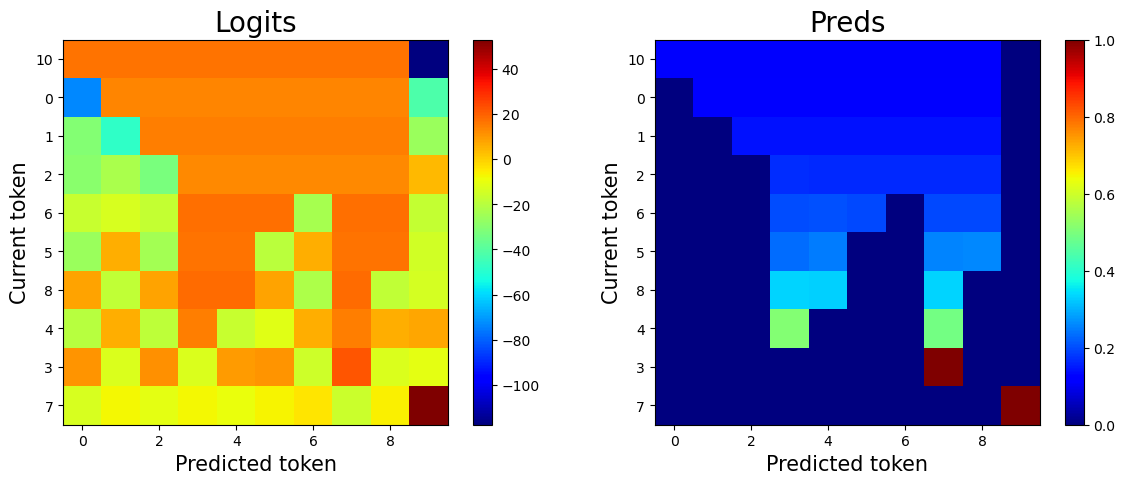

In [16]:
interpretability.plot_predictions(
    new_game, model(torch.tensor(new_game, requires_grad=False))
)

The shape of the logits and predictions are different from before, but the logic is the same. The values at (4,3) and (4,7) in the preds graph tell us the probability the model assigns to tokens 3 and 7 being the next tokens. Notice how (7,9) has a value of 1. This is the value we'll pay attention to during the next experiments.

Now let's ablate the attention mechanism 

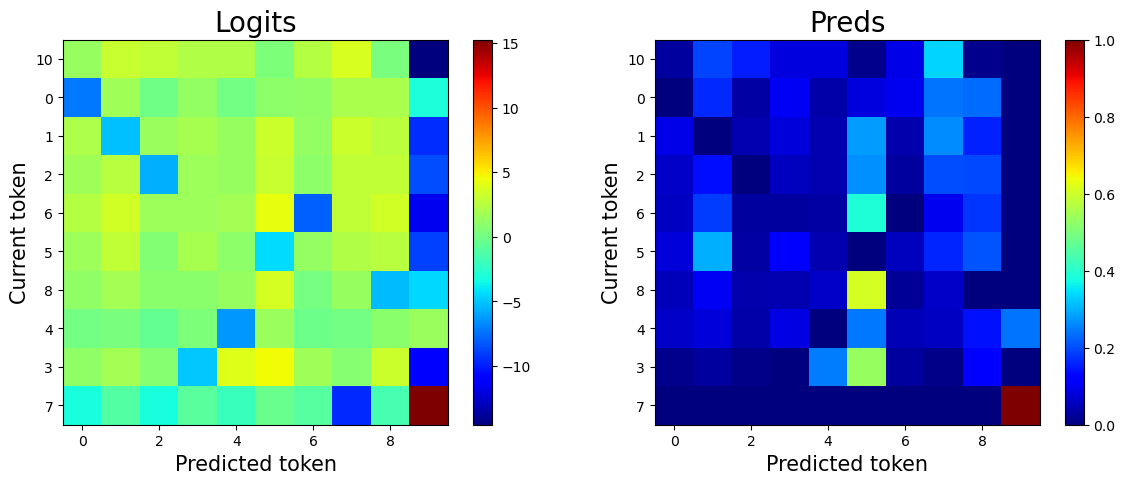

In [20]:
def zero_output(module, input, output):
    return torch.zeros_like(output)


handles = []
handles.append(model.blocks[0].attn.register_forward_hook(zero_output))
interpretability.plot_predictions(new_game, model(torch.tensor(new_game)))
[h.remove() for h in handles]
handles = list()

The value at (7,9) in the preds graph still has a value of 1. This means the model
still correctly predicts the game's over, even without attention!

This means knowing when a game is a draw must involve the embeddings (embedding, unembedding and positional) and the MLP

Note: A game is always over after 9 moves have been played. Either a player won, or the game is a draw. Since token 9 is the generic 'game over' token, this means the model will always predict token 9 after 9 moves have been played

Let's check how the positional embedding interacts with various parts of the model. The key value to watch for is still (7,9)

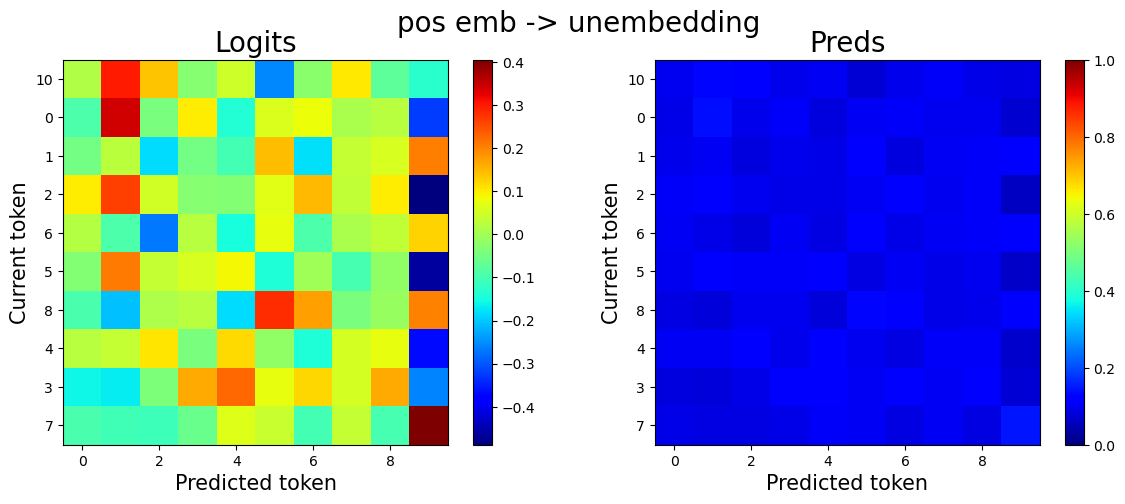

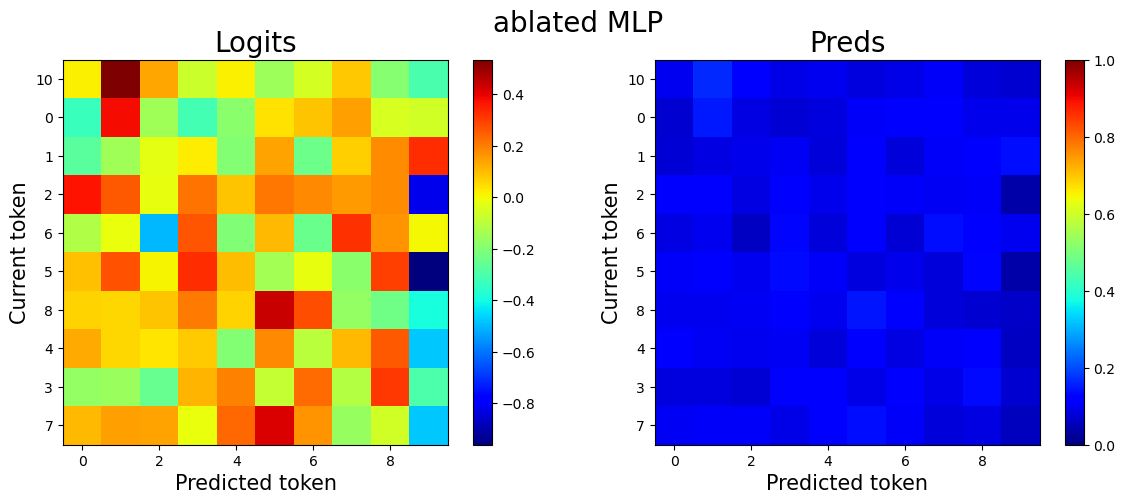

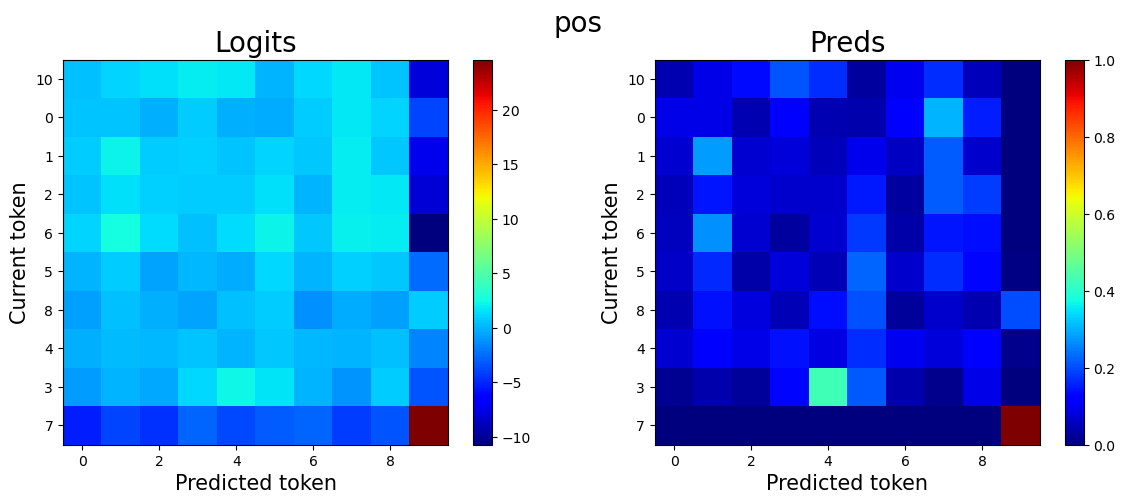

In [22]:
# generic positional embedding for our game
pos_emb = model.pos_embed(torch.zeros(1, 10), 0)
# pass embedding data through the MLP only
logits_mlp_pos = model.blocks[0].mlp(pos_emb) @ model.W_U
# directly unembed the positional embedding
logits_pos = pos_emb @ model.W_U
interpretability.plot_predictions(
    new_game, logits_pos, suptitle="pos emb -> unembedding"
)
interpretability.plot_predictions(
    new_game, interpretability.ablate_mlp(model, new_game), suptitle="ablated MLP"
)
interpretability.plot_predictions(new_game, logits_mlp_pos, suptitle="pos")

When we ablate the MLP, the model still somewhat correctly predicts the end game token. But if we use *just* the MLP, the model predicts it perfectly! This is a smoking gun: The model uses the MLP and positional information to predict token 9 when 9 moves have been played.

To understand this in more depth, we'll need to dig into the MLP, and to do that we'll need to understand a bit more about the dataset

There are ~255k possible games of tic-tac-toe, and just over half of those games end in 9 moves. Our MLP has 512 neurons in it. If we take the average loss of ablating a neuron across all 255k games, we should be able to see something interesting.

### Details about plot generation, feel free to skip

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [102]:
ablations_df = pd.read_csv("../data/230807_mlp_neuron_ablations.csv")
losses_df = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
print(losses_df.columns)
print(ablations_df.columns)

Index(['moves played', 'steps till end state', 'winner', 'rotation 1',
       'rotation 2', 'rotation 3', 'horizontal flip', 'vertical flip',
       'training index', 'train or test', 'first win condition',
       'second win condition', 'end move loss'],
      dtype='object')
Index(['moves played', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=513)


/tmp/ipykernel_4508/3902525130.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  losses_df = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')


In [103]:
losses_df = losses_df[["moves played", "first win condition", "end move loss"]]
# convert ablations_df to object
ablations_df = ablations_df.astype(object)

In [104]:
ablations_df["moves played"] = losses_df["moves played"]

In [105]:
ablations_df.head()

,moves played,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,"[0, 1, 3, 2, 6]",0.000008,0.000008,0.000497,0.00001,0.000001,1.097605,0.000004,0.000005,0.000002,...,0.000005,0.0,0.000003,0.000004,0.000002,0.000005,0.000006,0.000008,0.000051,0.000006
1,"[0, 1, 3, 4, 6]",0.000195,0.000189,0.036626,0.000232,0.000003,3.076243,0.000077,0.000098,0.000029,...,0.000118,0.000012,0.000041,0.000081,0.000042,0.0001,0.000123,0.000181,0.000794,0.000149
2,"[0, 1, 3, 5, 6]",0.000011,0.000011,0.000807,0.000013,0.0,1.423348,0.000005,0.000005,0.000003,...,0.000006,0.000001,0.000002,0.000003,0.000003,0.000005,0.000007,0.00001,0.000073,0.000009
3,"[0, 1, 3, 7, 6]",0.000015,0.000014,0.00213,0.000017,0.000001,1.009675,0.000005,0.000007,0.000003,...,0.000009,0.000001,0.000003,0.000005,0.000004,0.000008,0.000008,0.000012,0.000072,0.00001
4,"[0, 1, 3, 8, 6]",0.000022,0.000021,0.001409,0.000025,0.000001,1.193816,0.00001,0.00001,0.000005,...,0.000014,0.000001,0.000008,0.000009,0.000005,0.000012,0.000013,0.000019,0.00013,0.000016


In [106]:
merged_df = pd.merge(ablations_df, losses_df, on="moves played", how="inner")

In [107]:
def add_epsilon(val, column):
    if column in ["moves played", "first win condition"]:
        return val
    return val + 10e-8


merged_df = merged_df.apply(lambda col: col.map(lambda val: add_epsilon(val, col.name)))

merged_df.iloc[-1]

moves played           [8, 7, 6, 5, 4, 3, 1, 2, 0]
0                                              0.0
1                                              0.0
2                                              0.0
3                                              0.0
                                  ...             
509                                            0.0
510                                            0.0
511                                            0.0
first win condition       top left -> bottom right
end move loss                                  0.0
Name: 255167, Length: 515, dtype: object

In [108]:
for col in merged_df.columns:
    if col not in ["moves played", "end move loss", "first win condition"]:
        merged_df[col] = np.log10(merged_df[col] / merged_df["end move loss"])

normalized_ablation_losses_df = merged_df.drop(columns=["end move loss"])

In [109]:
normalized_ablation_losses_df.head()
# count all nans
normalized_ablation_losses_df.isna().sum().sum()

46080

In [126]:
losses_df = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
# first row where moves played is >5
game_position_5 = losses_df[losses_df["steps till end state"] > 5].index[0]
game_position_6 = losses_df[losses_df["steps till end state"] > 6].index[0]
game_position_7 = losses_df[losses_df["steps till end state"] > 7].index[0]
game_position_8 = losses_df[losses_df["steps till end state"] > 8].index[0]

/tmp/ipykernel_4508/165625124.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  losses_df = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")


### Plotting average loss after neuron ablations across all games

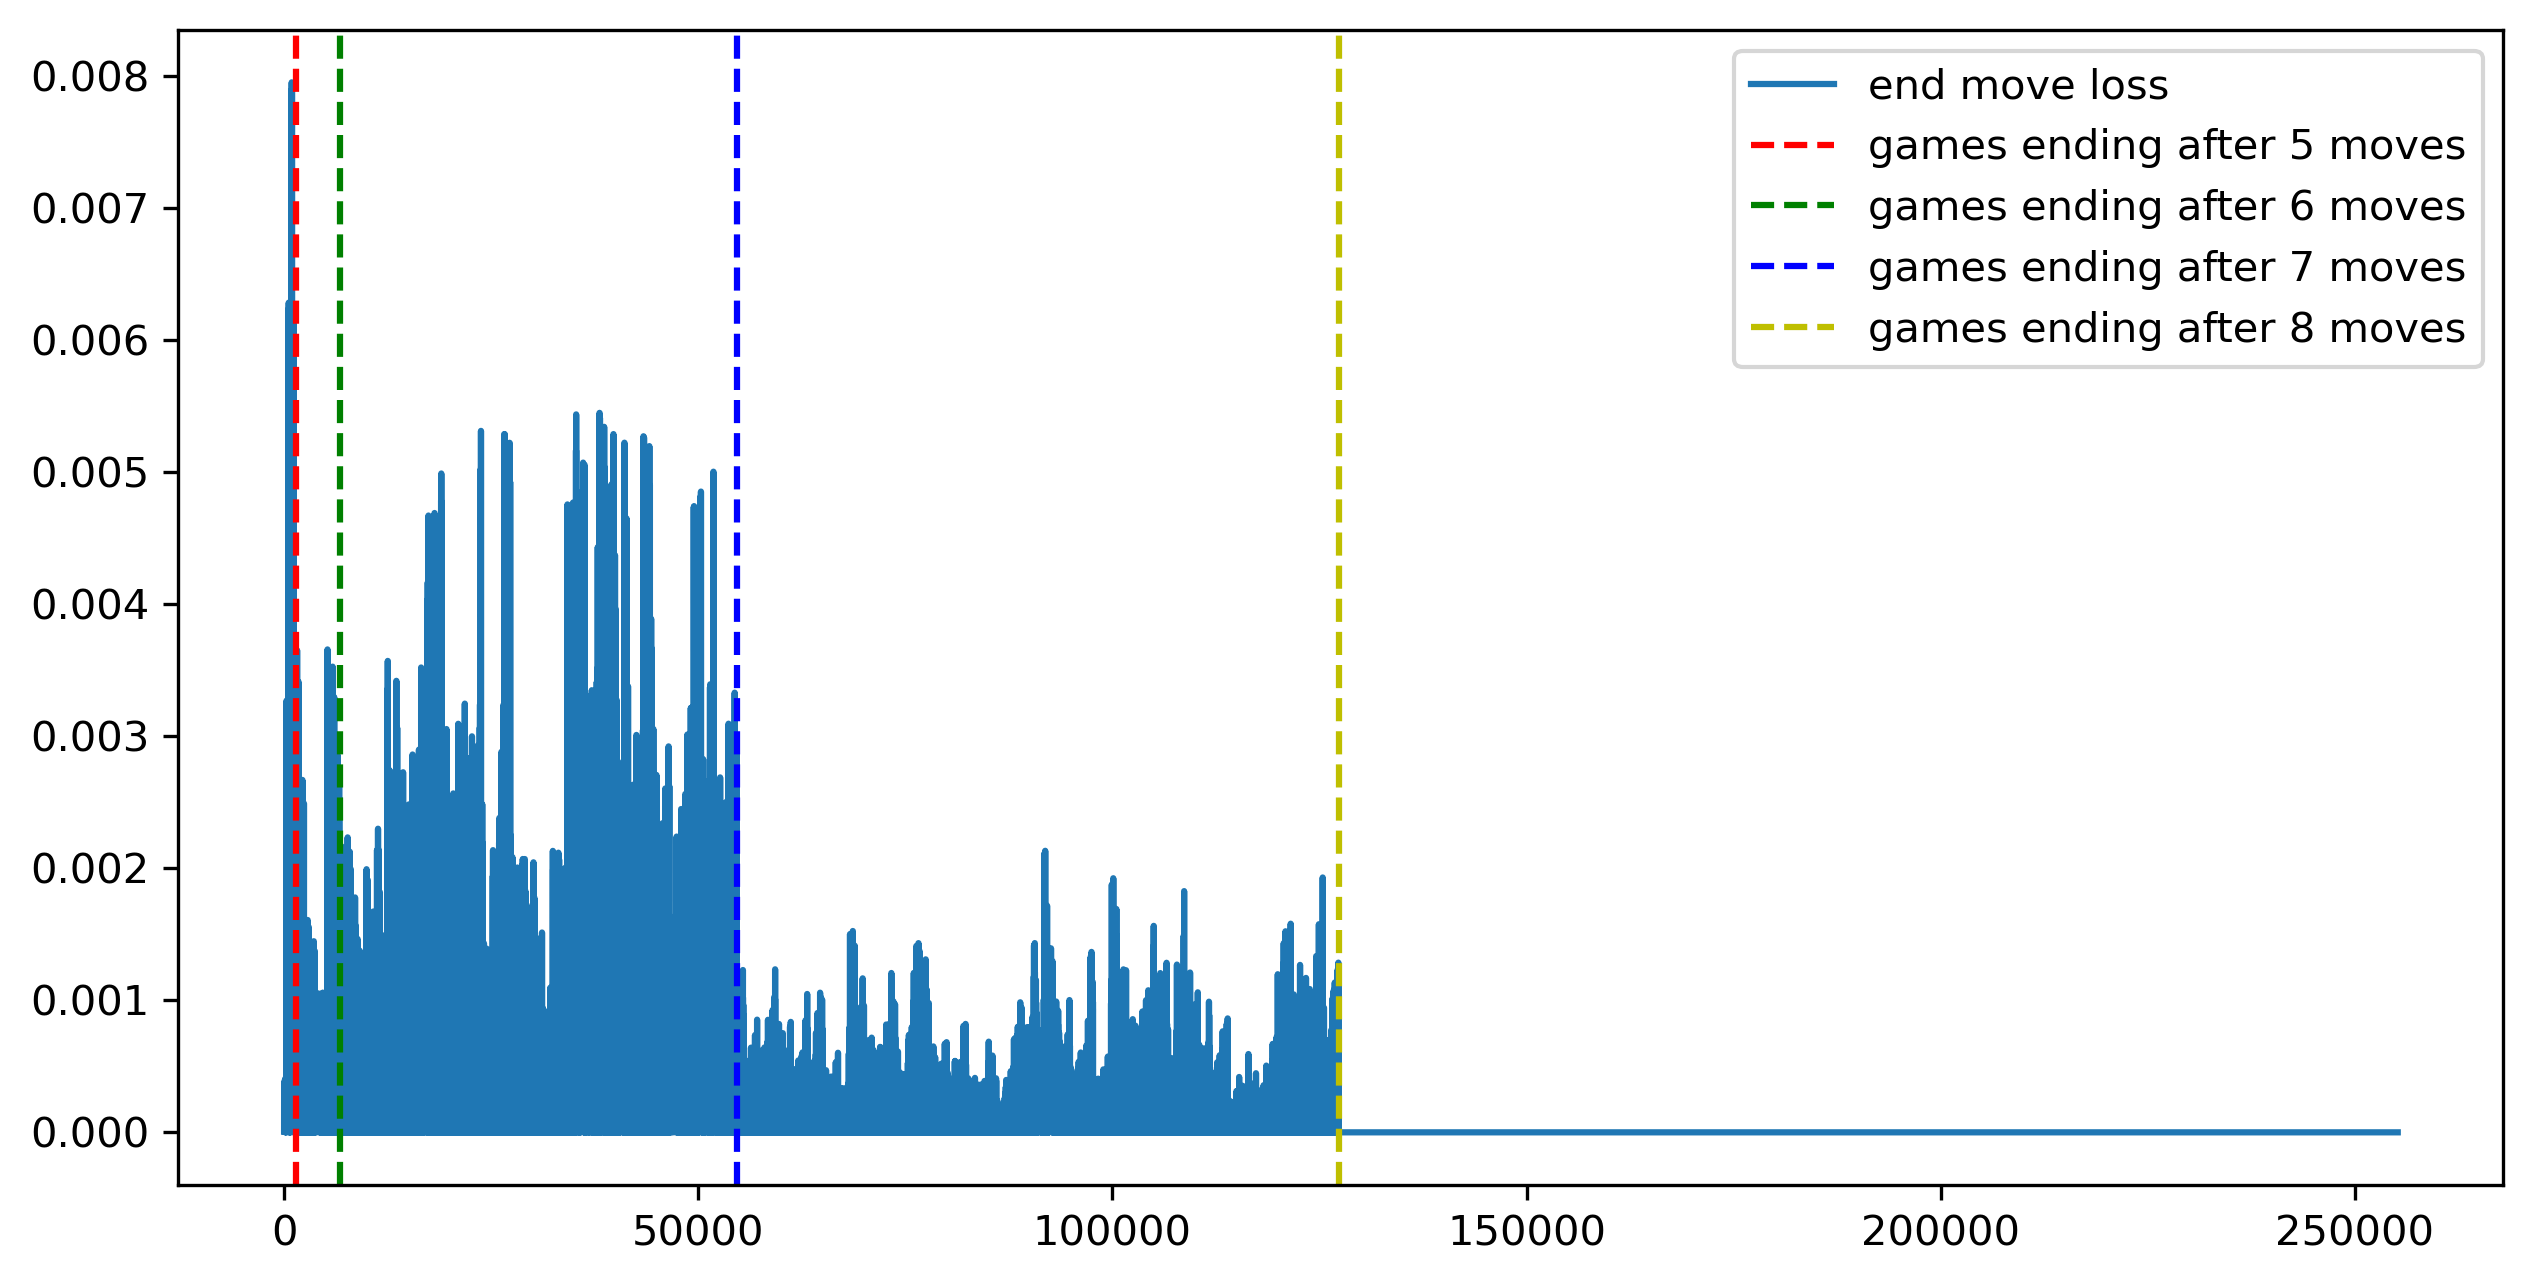

In [127]:
# plot losses_df 'moves played' vs 'end move loss'
plt.figure(figsize=(10, 5))
# fig dpi
plt.rcParams["figure.dpi"] = 300
plt.plot(losses_df["end move loss"], label="end move loss")
# plot vertical line at game_position_5
plt.axvline(
    x=game_position_5, color="r", linestyle="--", label="games ending after 5 moves"
)
plt.axvline(
    x=game_position_6, color="g", linestyle="--", label="games ending after 6 moves"
)
plt.axvline(
    x=game_position_7, color="b", linestyle="--", label="games ending after 7 moves"
)
plt.axvline(
    x=game_position_8, color="y", linestyle="--", label="games ending after 8 moves"
)
# legend
plt.legend(loc="upper right")
plt.show()

This graph partitions the total games by how long they take to finish, with our example game existing in the last half of this graph (games ending after 9 moves). The y axis is the average loss caused by ablating an arbitrary neuron in the MLP.   

The key feature is that the average loss goes to ~0 in the last half. 

Why? Our hypothesis is that a large portion of neurons are responsible for taking in the positional information, so that ablating any particular neuron has a negligable effect on the loss. If you look at the predictions of the "pos emb -> mlp -> unembedding" plot above, the logit value for token 9 is ~24, while the logit value for *any* of the other tokens is at most, -5. This means the marginal change in the predictions by ablating, say, one neuron out of 100, is incredibly small, especially after we take the softmax into account.

### Some code demonstrating the effect, feel free to skip


In [115]:
loss_fn = torch.nn.functional.cross_entropy
# target is 1,0. Our psuedo logits aim for this
target = torch.tensor([1.0, 0.0])

positive_contributions = torch.randn(100) + 1
negative_contributions = torch.randn(100) - 1
# simulate some neuron activations
neuron_contributions = torch.stack([positive_contributions, negative_contributions])

# add them together
sum_contributions = einops.reduce(
    neuron_contributions, "logits neurons -> logits", "sum"
)

# our loss is now 0
loss = loss_fn(sum_contributions, target)
print("pre-ablated loss is", loss)

# we ablate some neurons
ablated_neurons = neuron_contributions
ablated_neurons[:, 10:13] = 0.0

# add them together
ablated_sum_contributions = einops.reduce(
    ablated_neurons, "logits neurons -> logits", "sum"
)

# our loss is still 0
loss = loss_fn(sum_contributions, target)
print("ablated loss is", loss)

### Section Takeaways
We've got a pretty good idea of where the model calculates if a game is over due to game length. It seems to use the positional embedding and a large amount of neurons in the MLP to calculate this. Although we don't know exactly which neurons are responsible, we know there are a lot of them, and they might also be polysemantic with some of the other game over conditions in the model.

### Other End-game States

Predicting a draw isn't the only thing this model does. As we saw at the beginning of this notebook, this model can also calculate when a player wins. Let's use the same game from earlier

In [133]:
example_game = [10, 0, 1, 2, 3, 4, 5, 6]
gm = game.play_game(example_game)
print(gm.get_state())

| X | O | X |
| O | X | O |
| X |   |   |
State.OVER


Let's take another look at the logits for this game. 

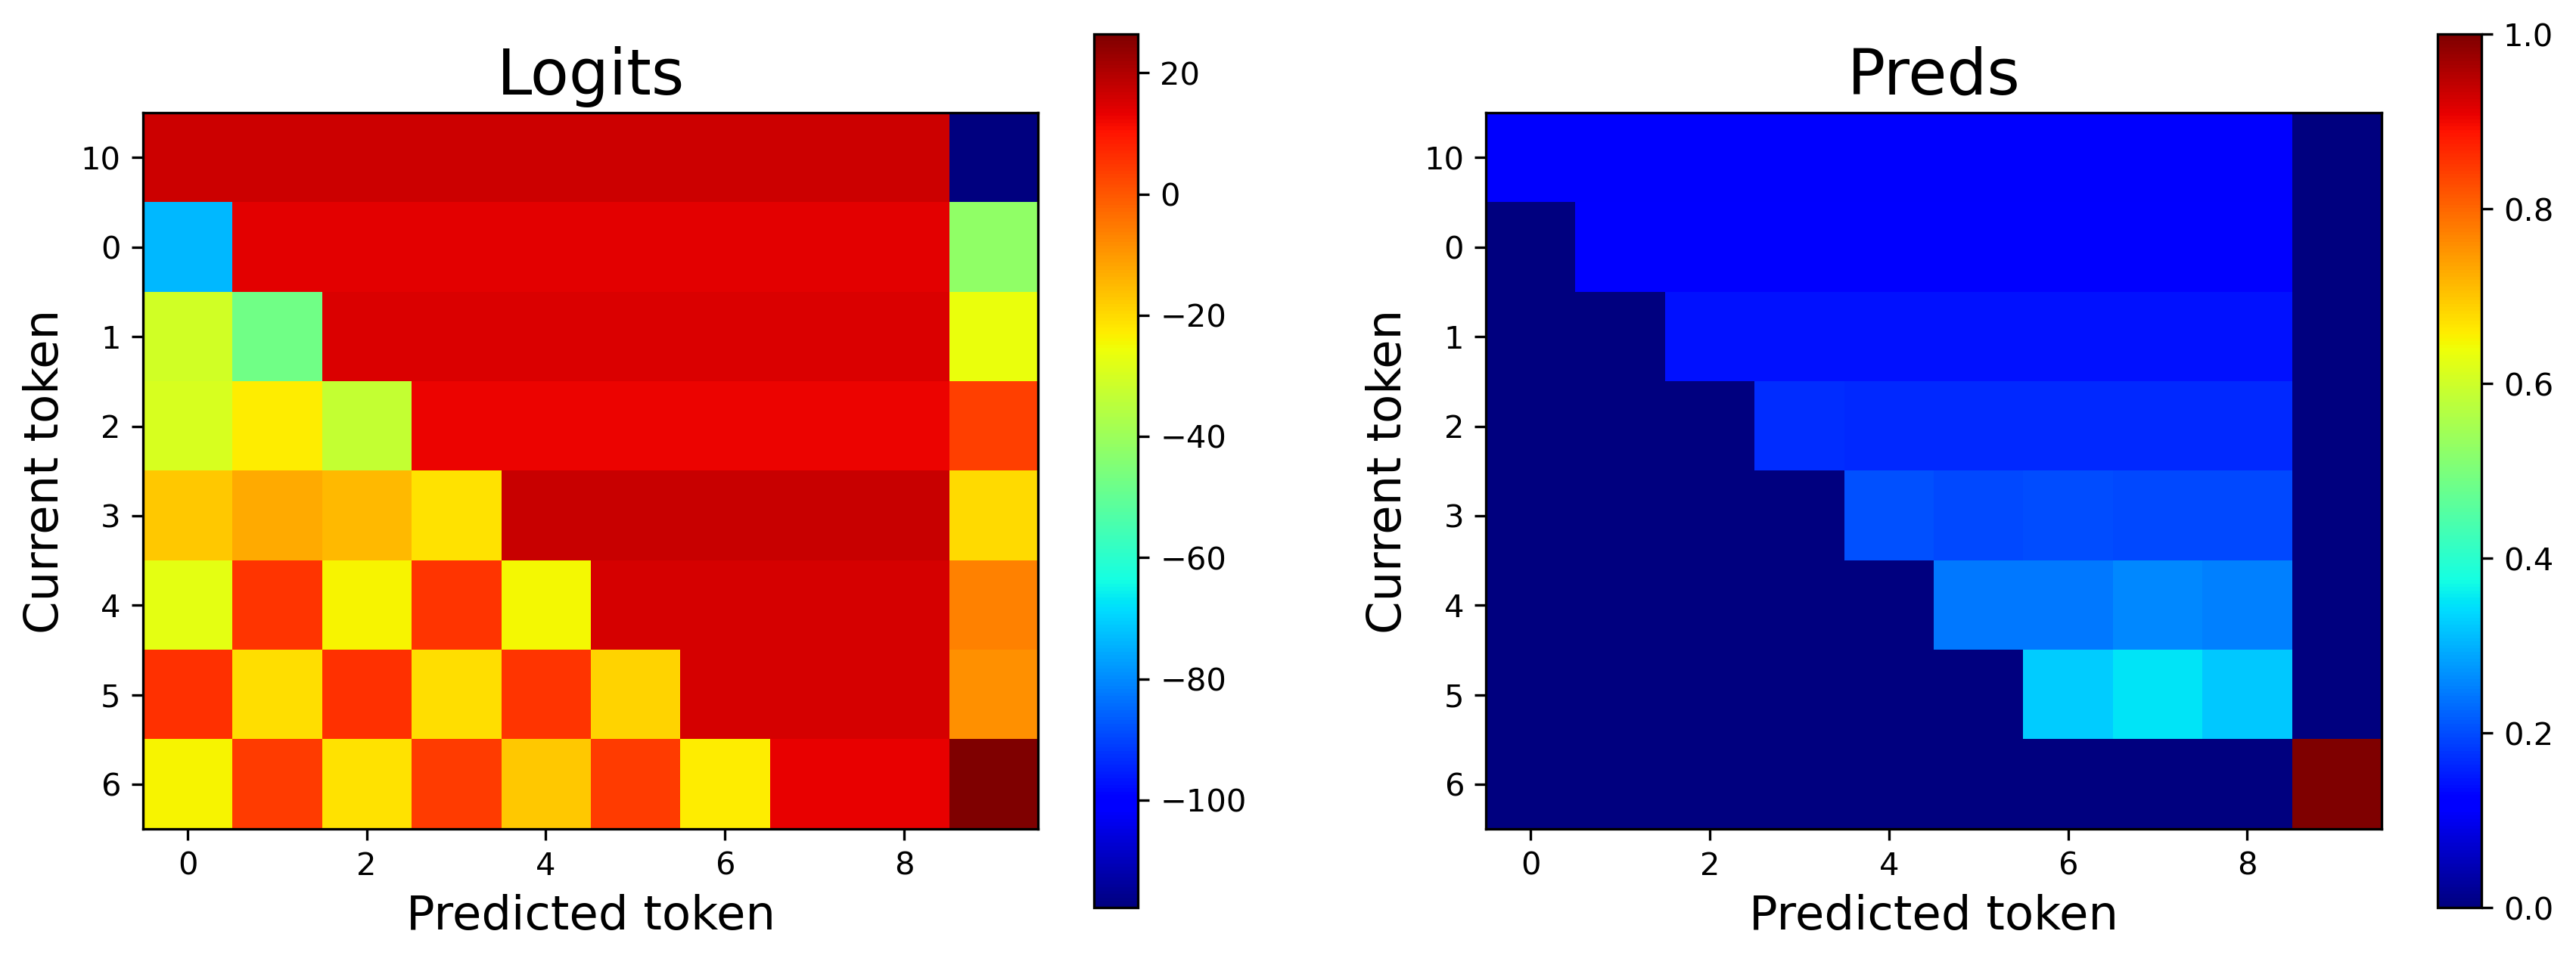

In [134]:
logits = model(torch.tensor(example_game))
interpretability.plot_predictions(example_game, logits)

Can we narrow down what's responsible for determining a game-over in this scenarios? It turns out that there's one head that's primarily responsible for determining when a game is over. Head 2

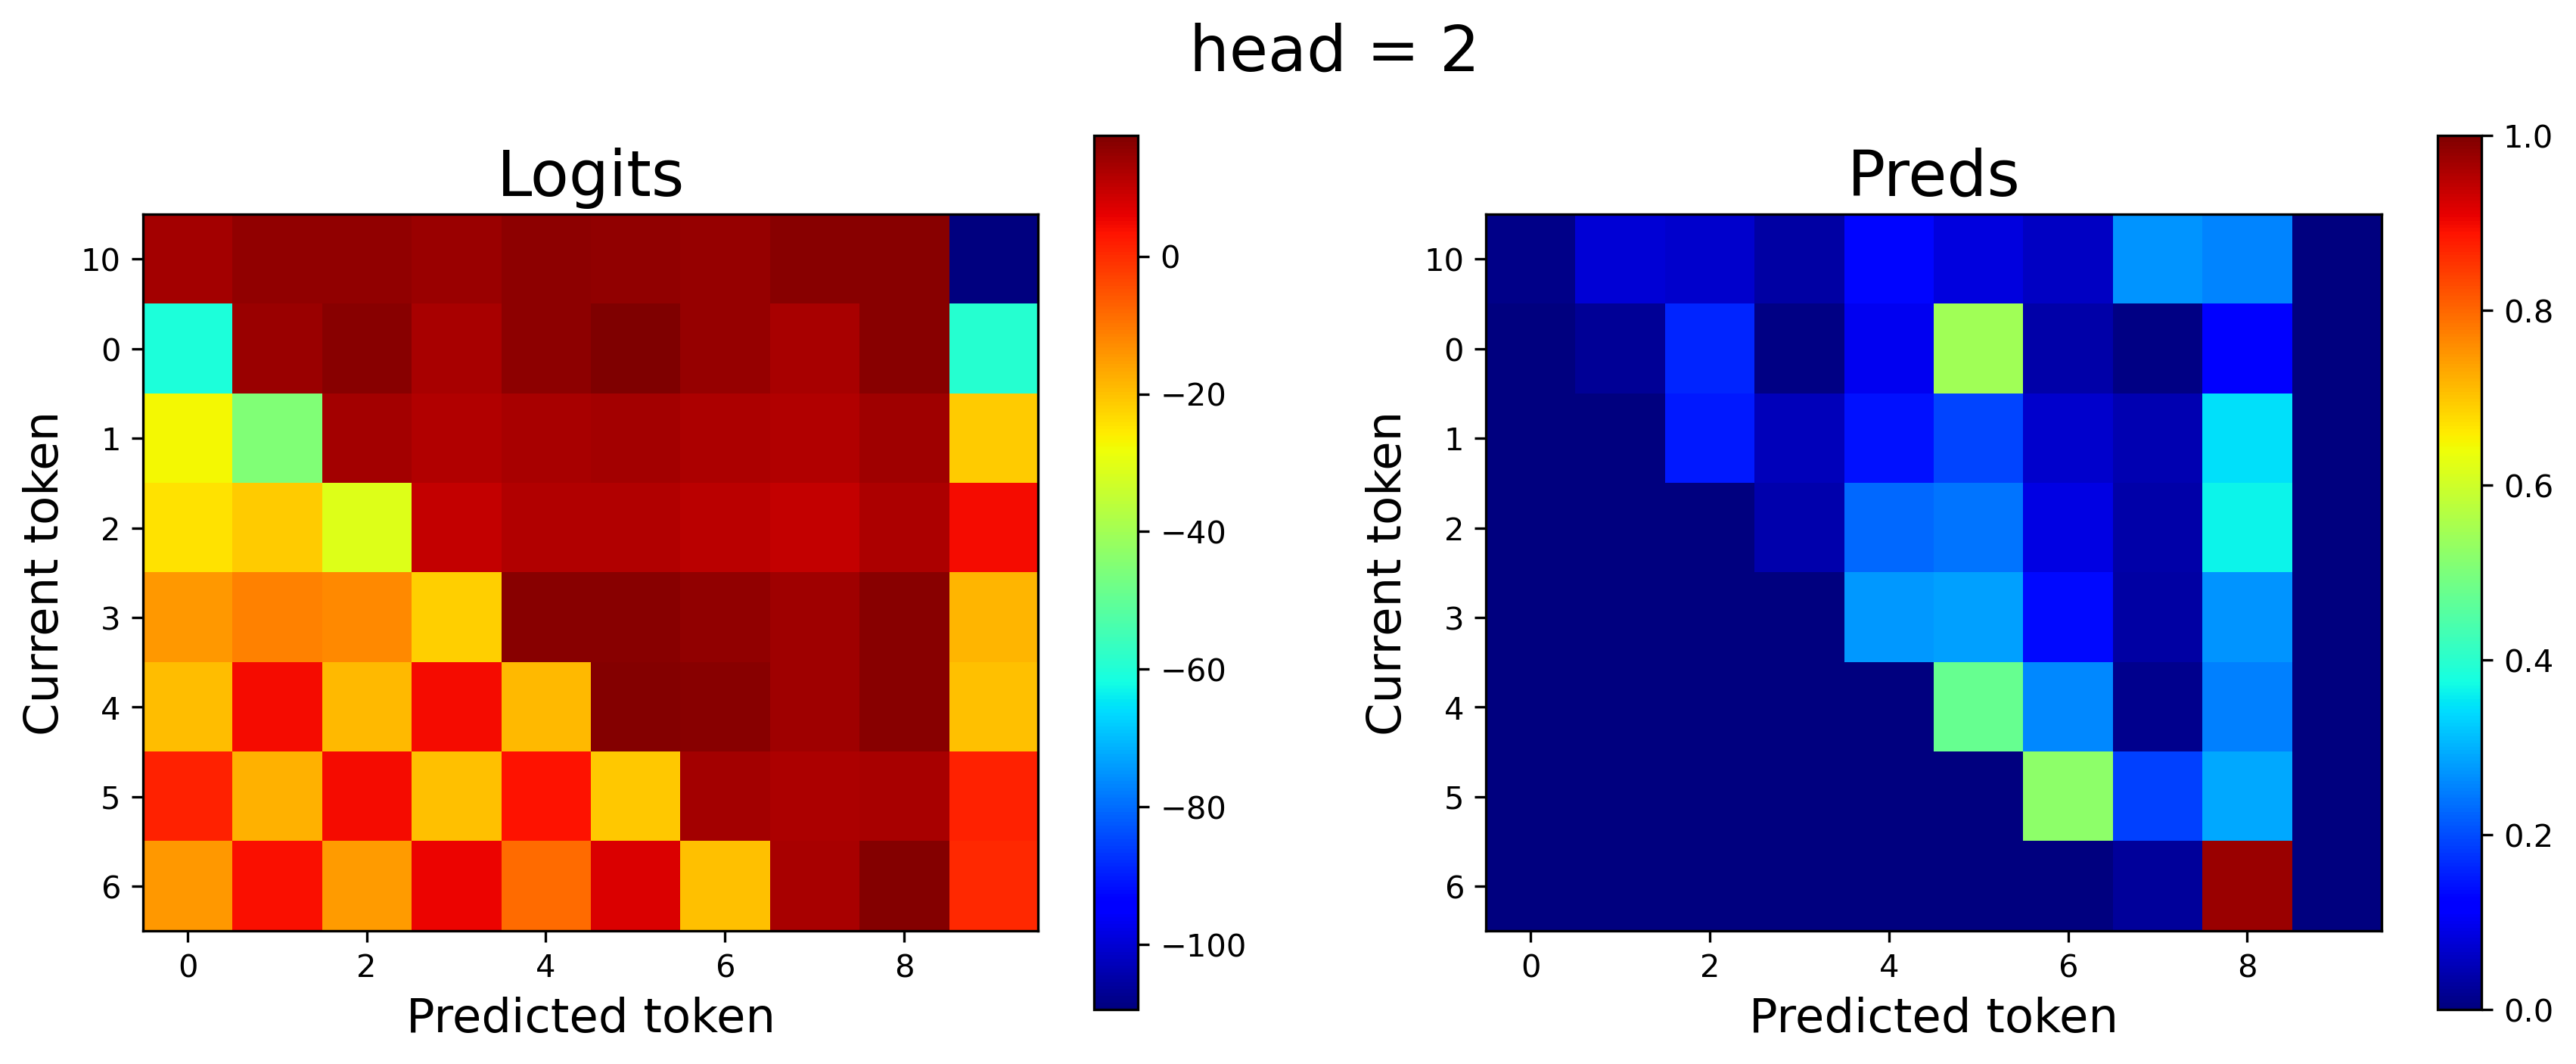

In [136]:
interpretability.plot_predictions(
    example_game,
    interpretability.ablate_one_head(model, 2, example_game),
    suptitle="head = 2",
)

### Showcase of other heads *not* disabling end-game calculation
feel free to skip

By looking at the predictions after token 6, we can see that the model stops correctly calculating end-state *only* after ablating head 2

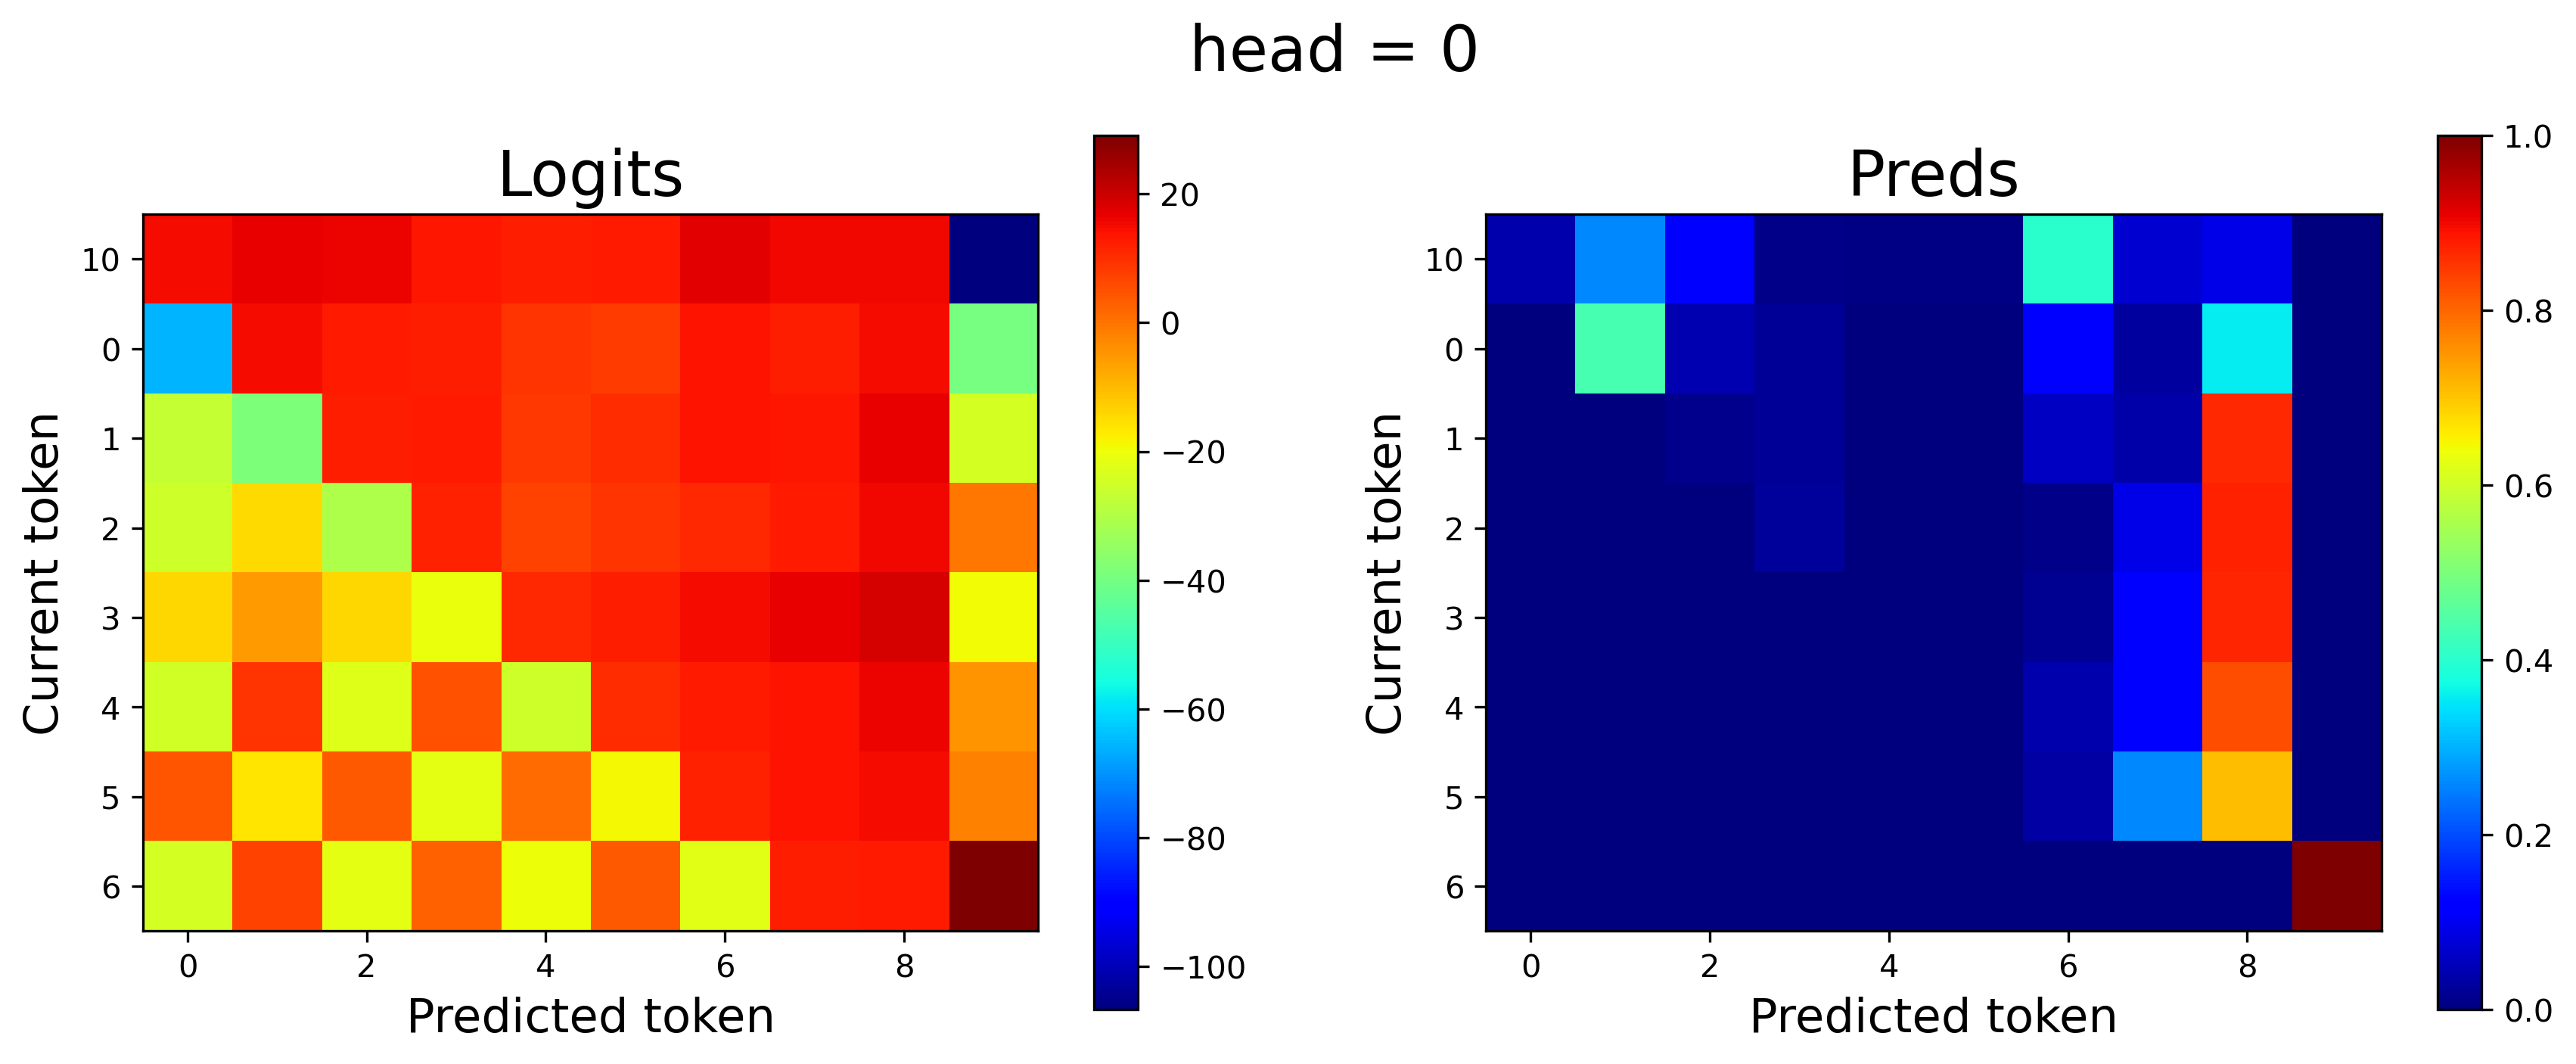

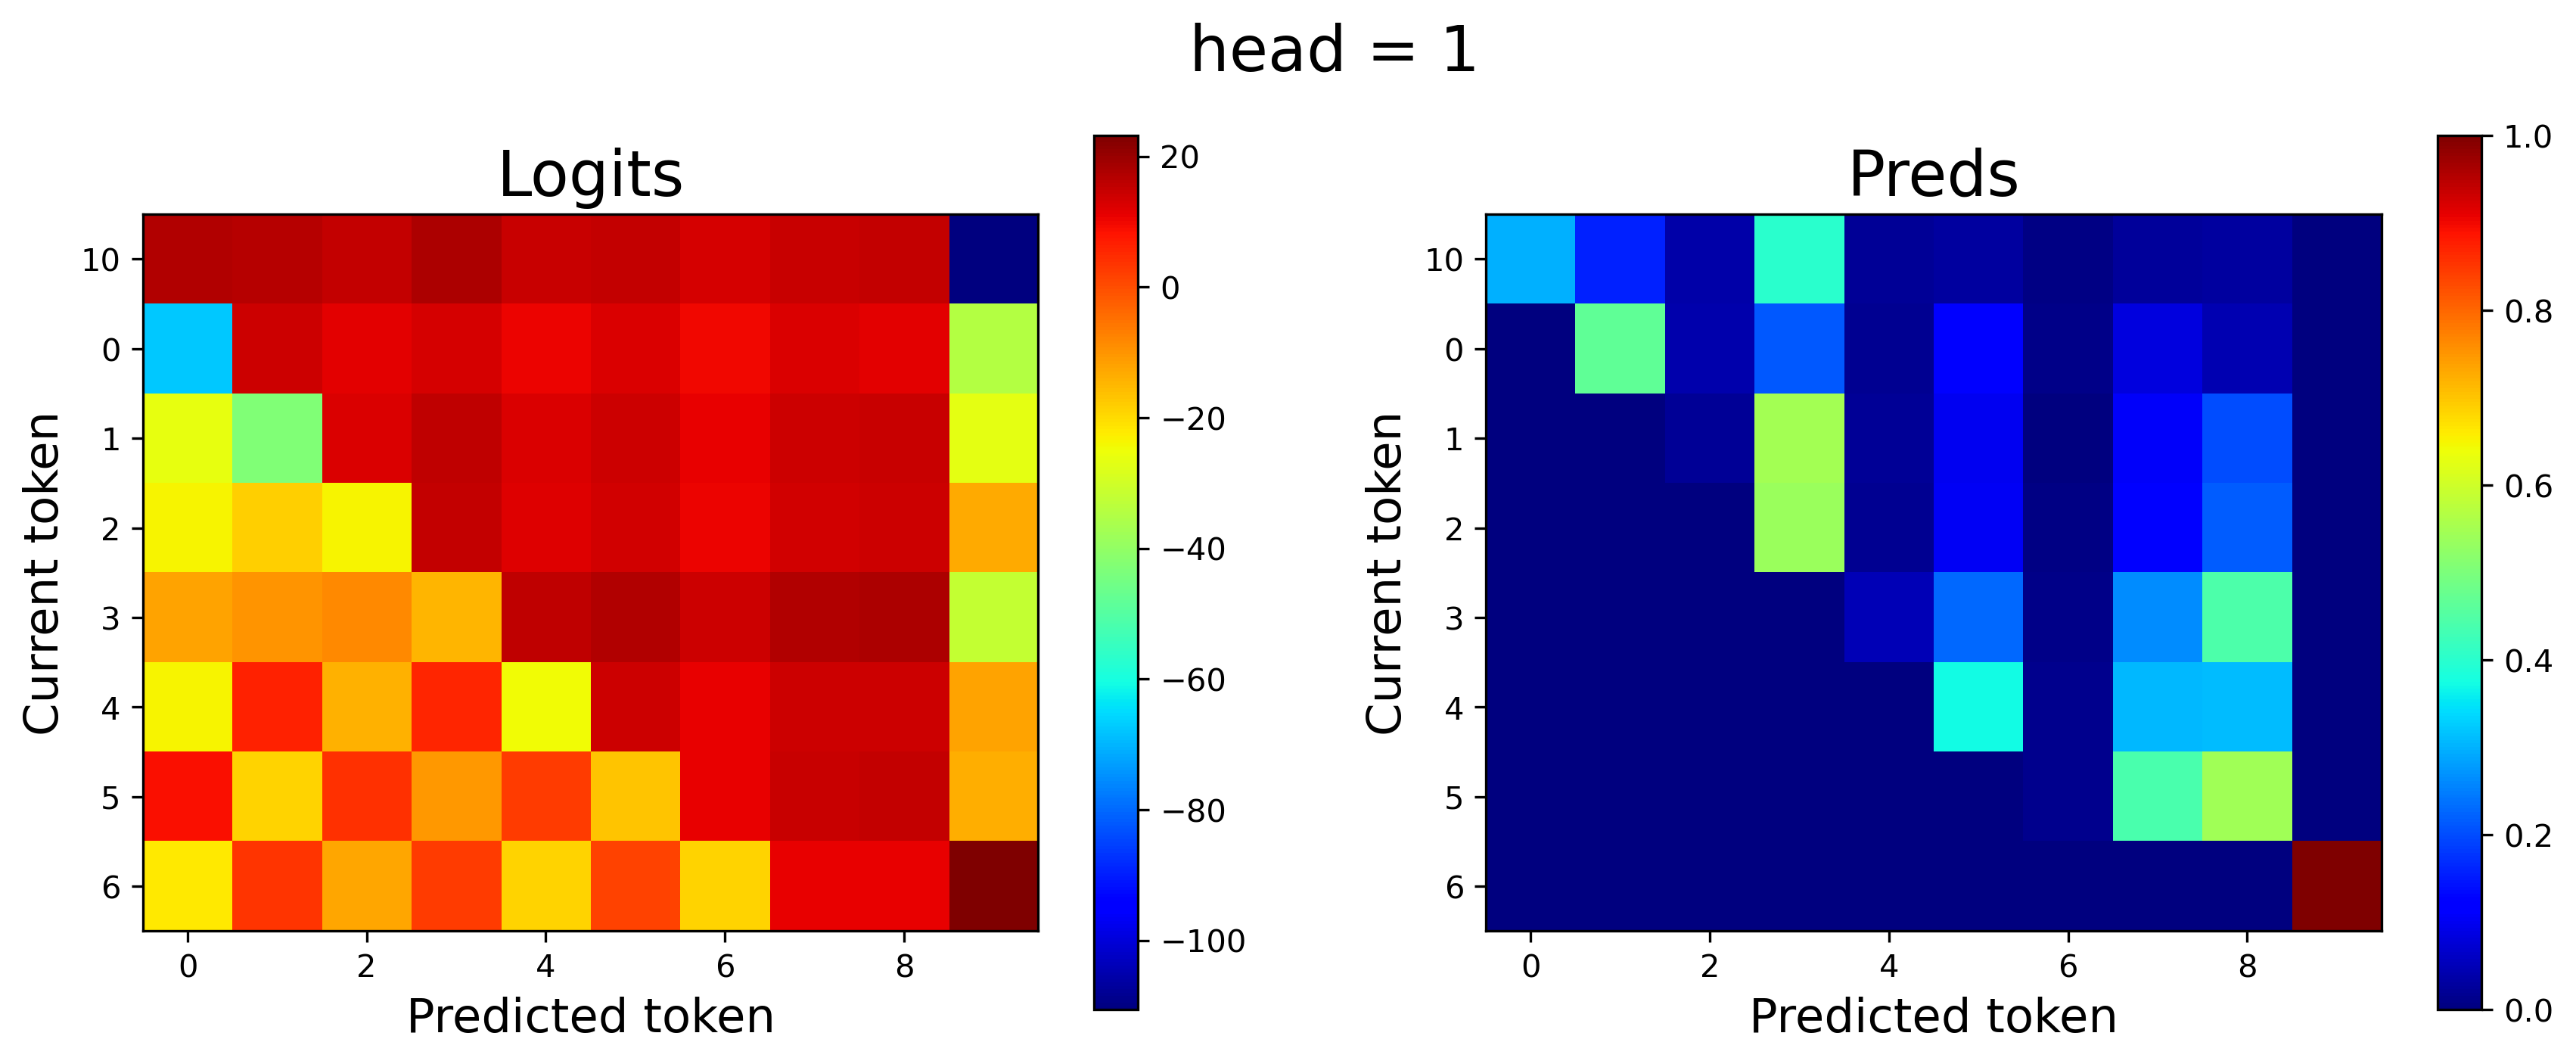

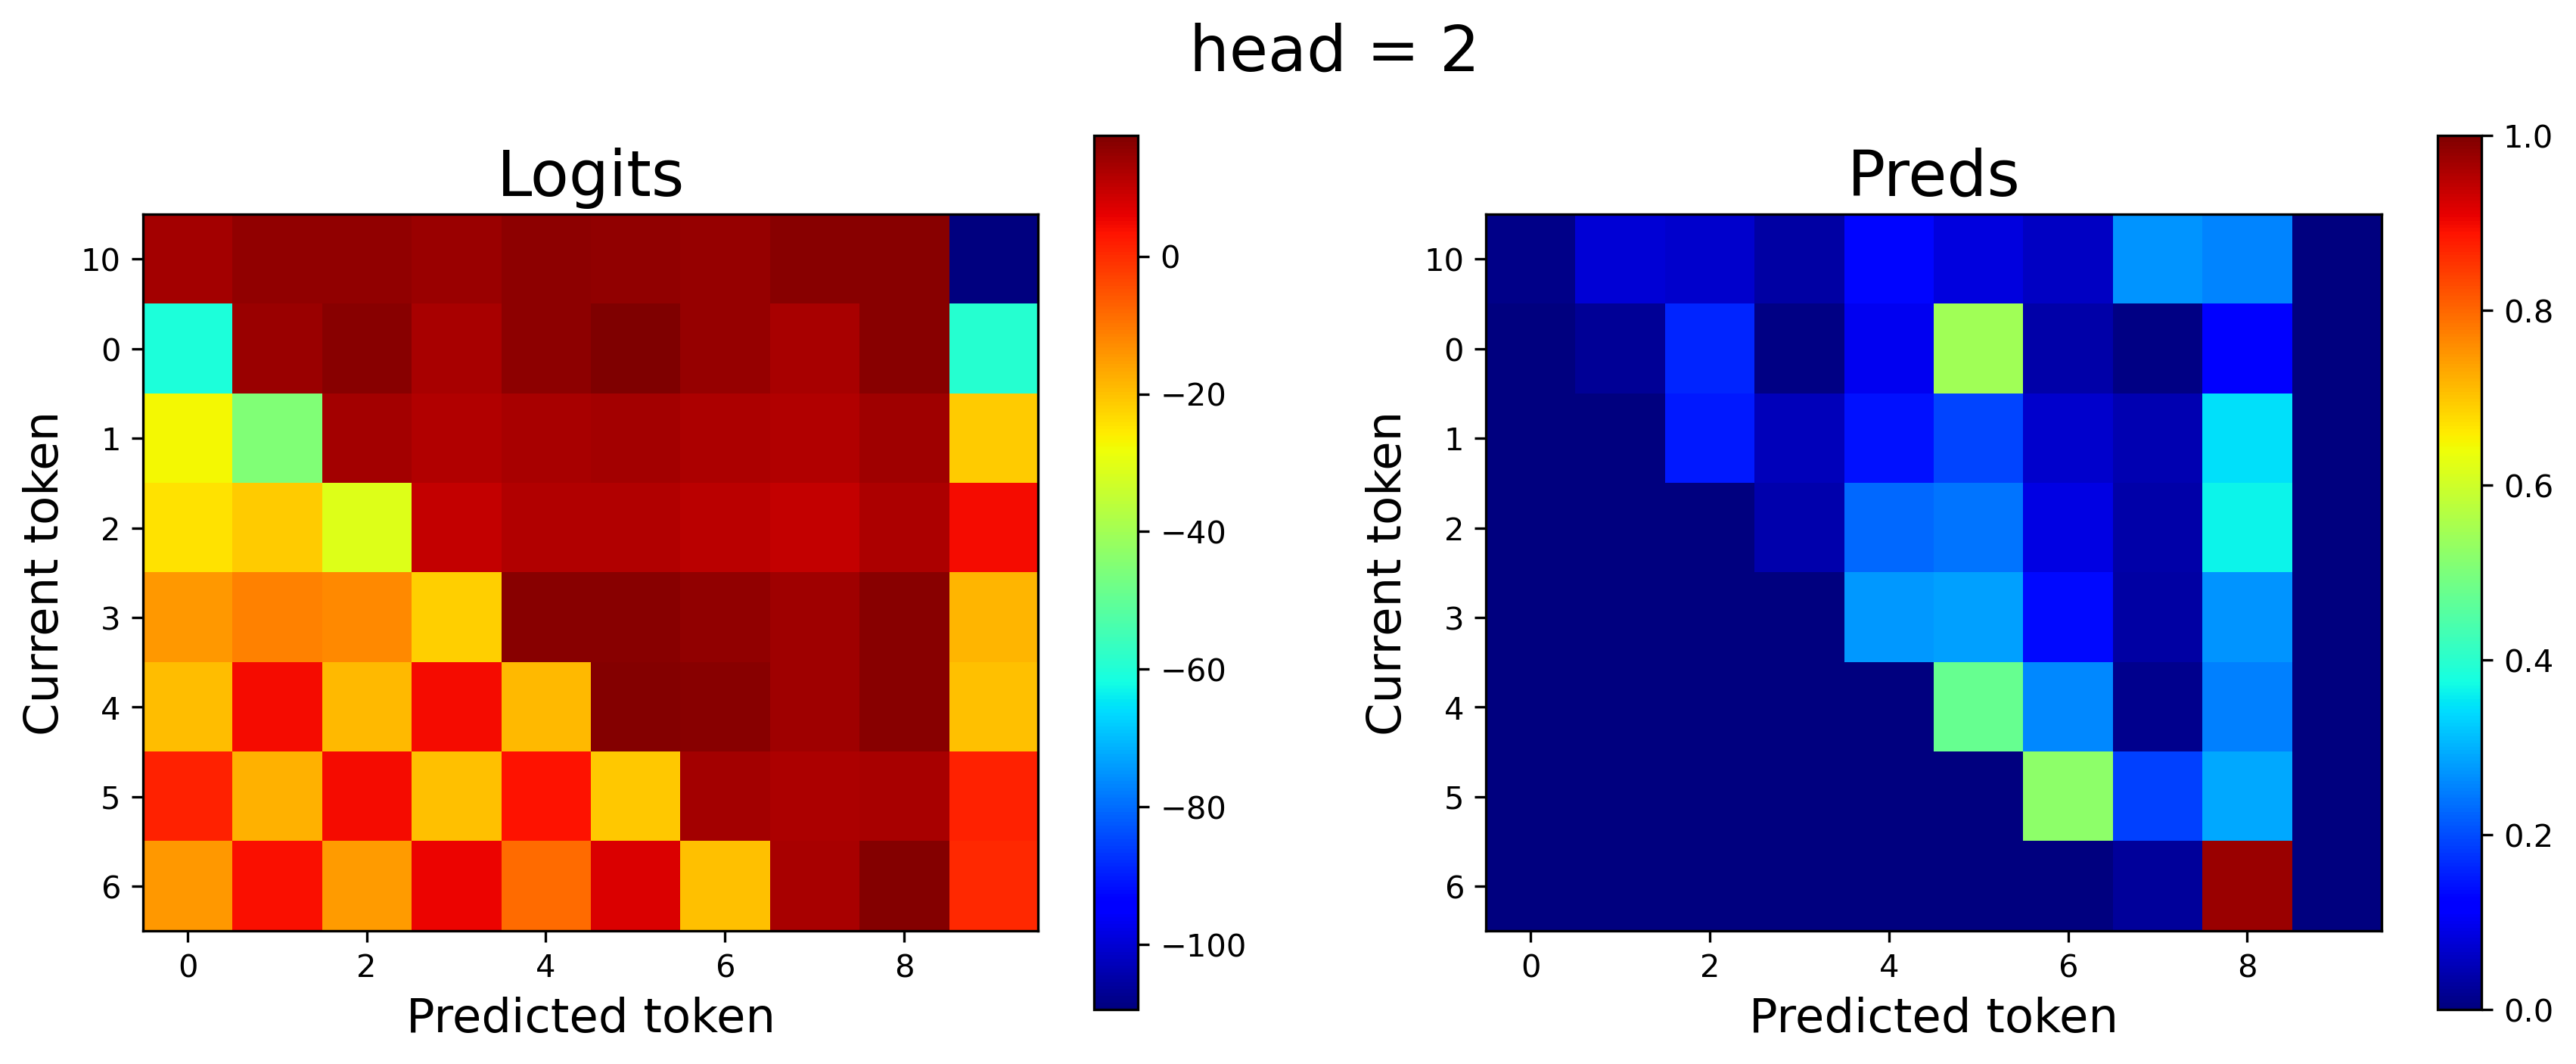

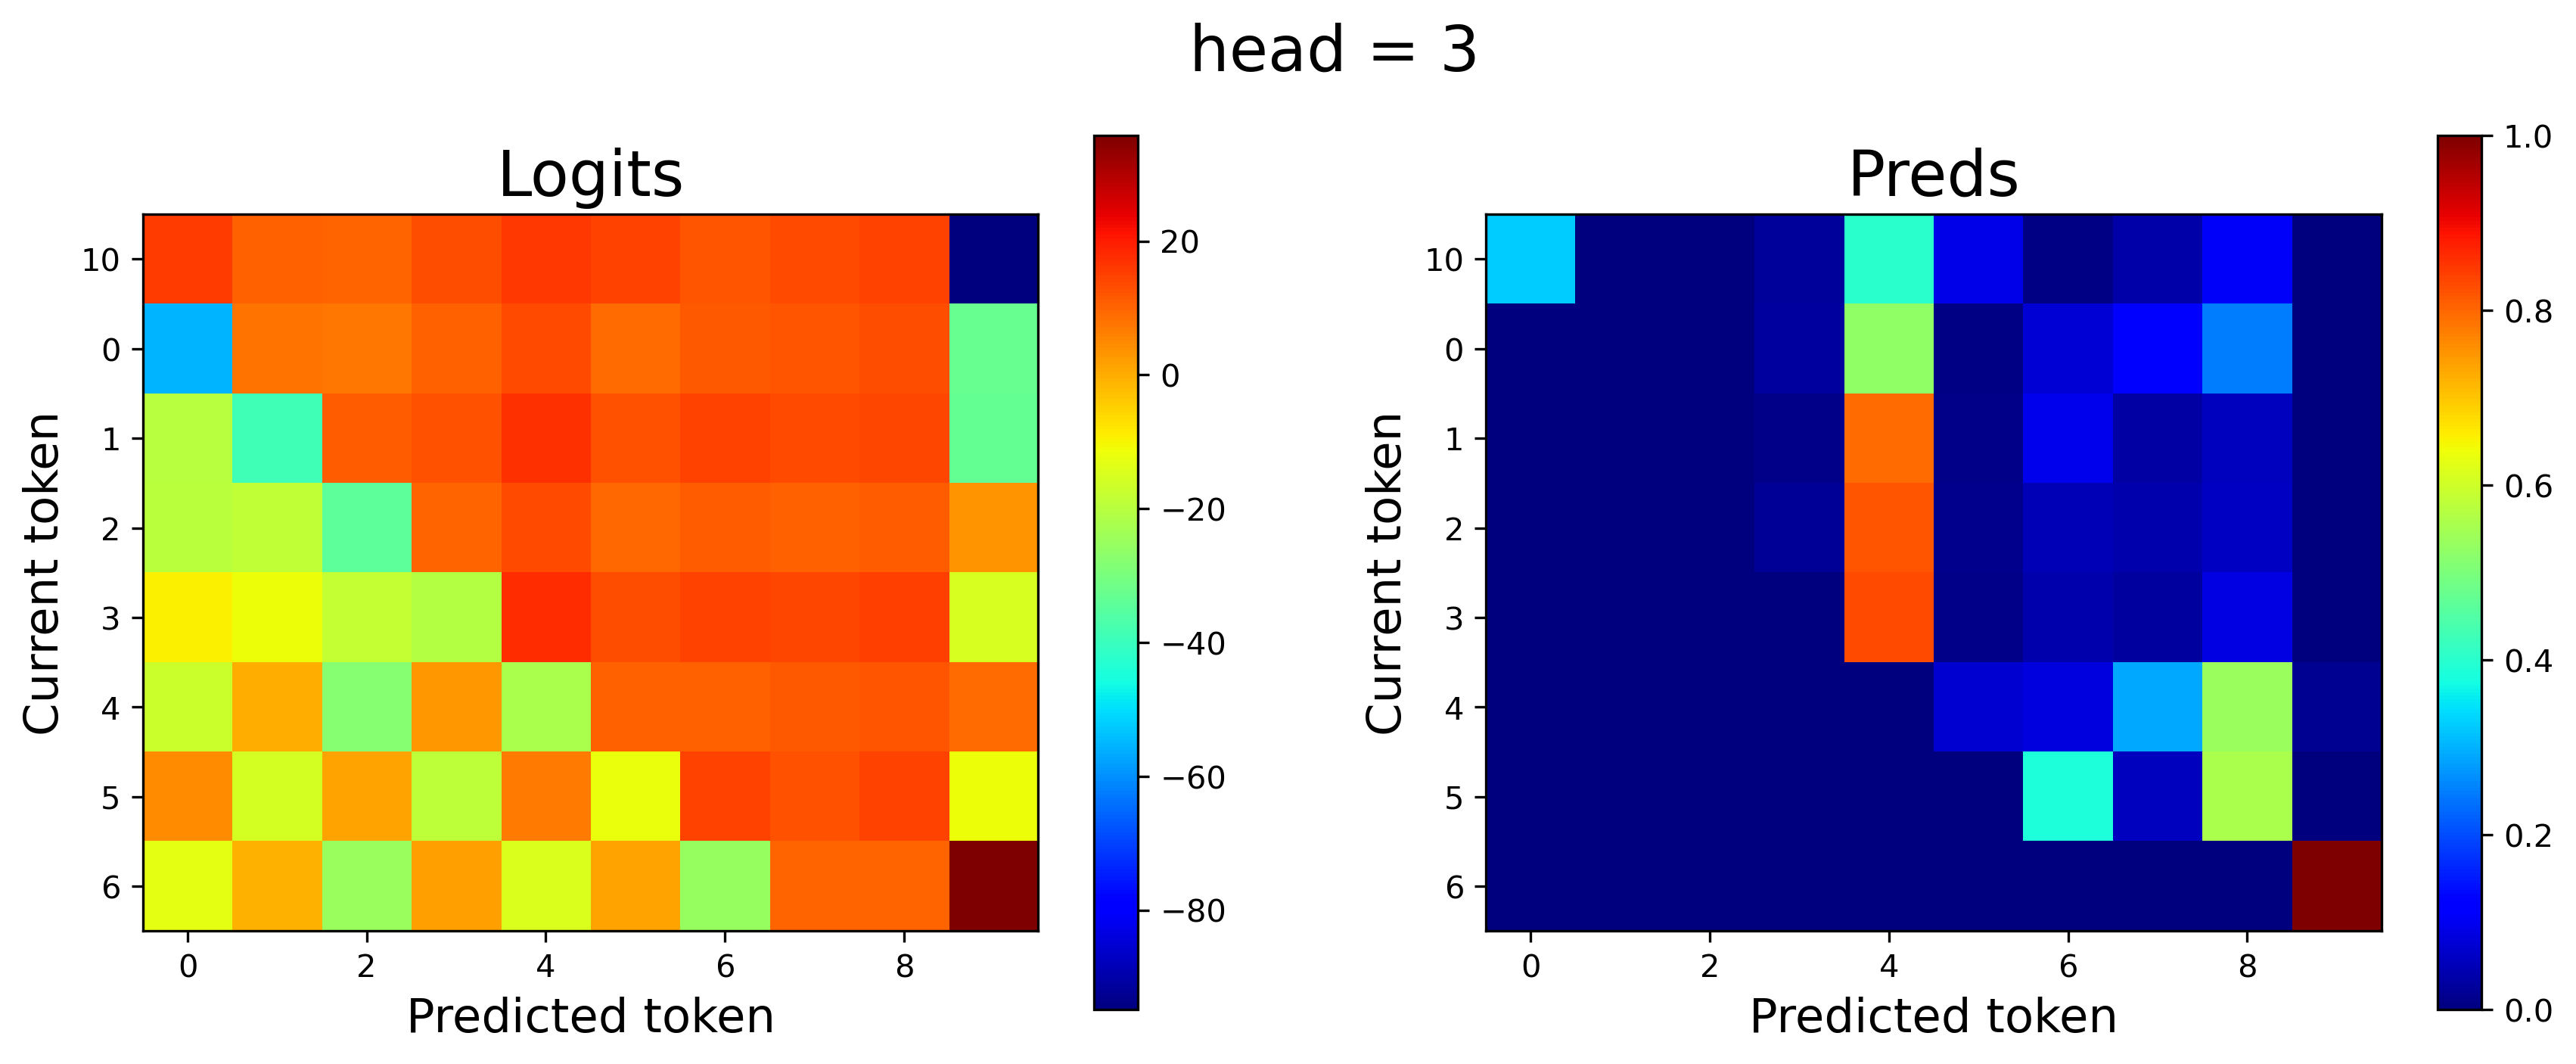

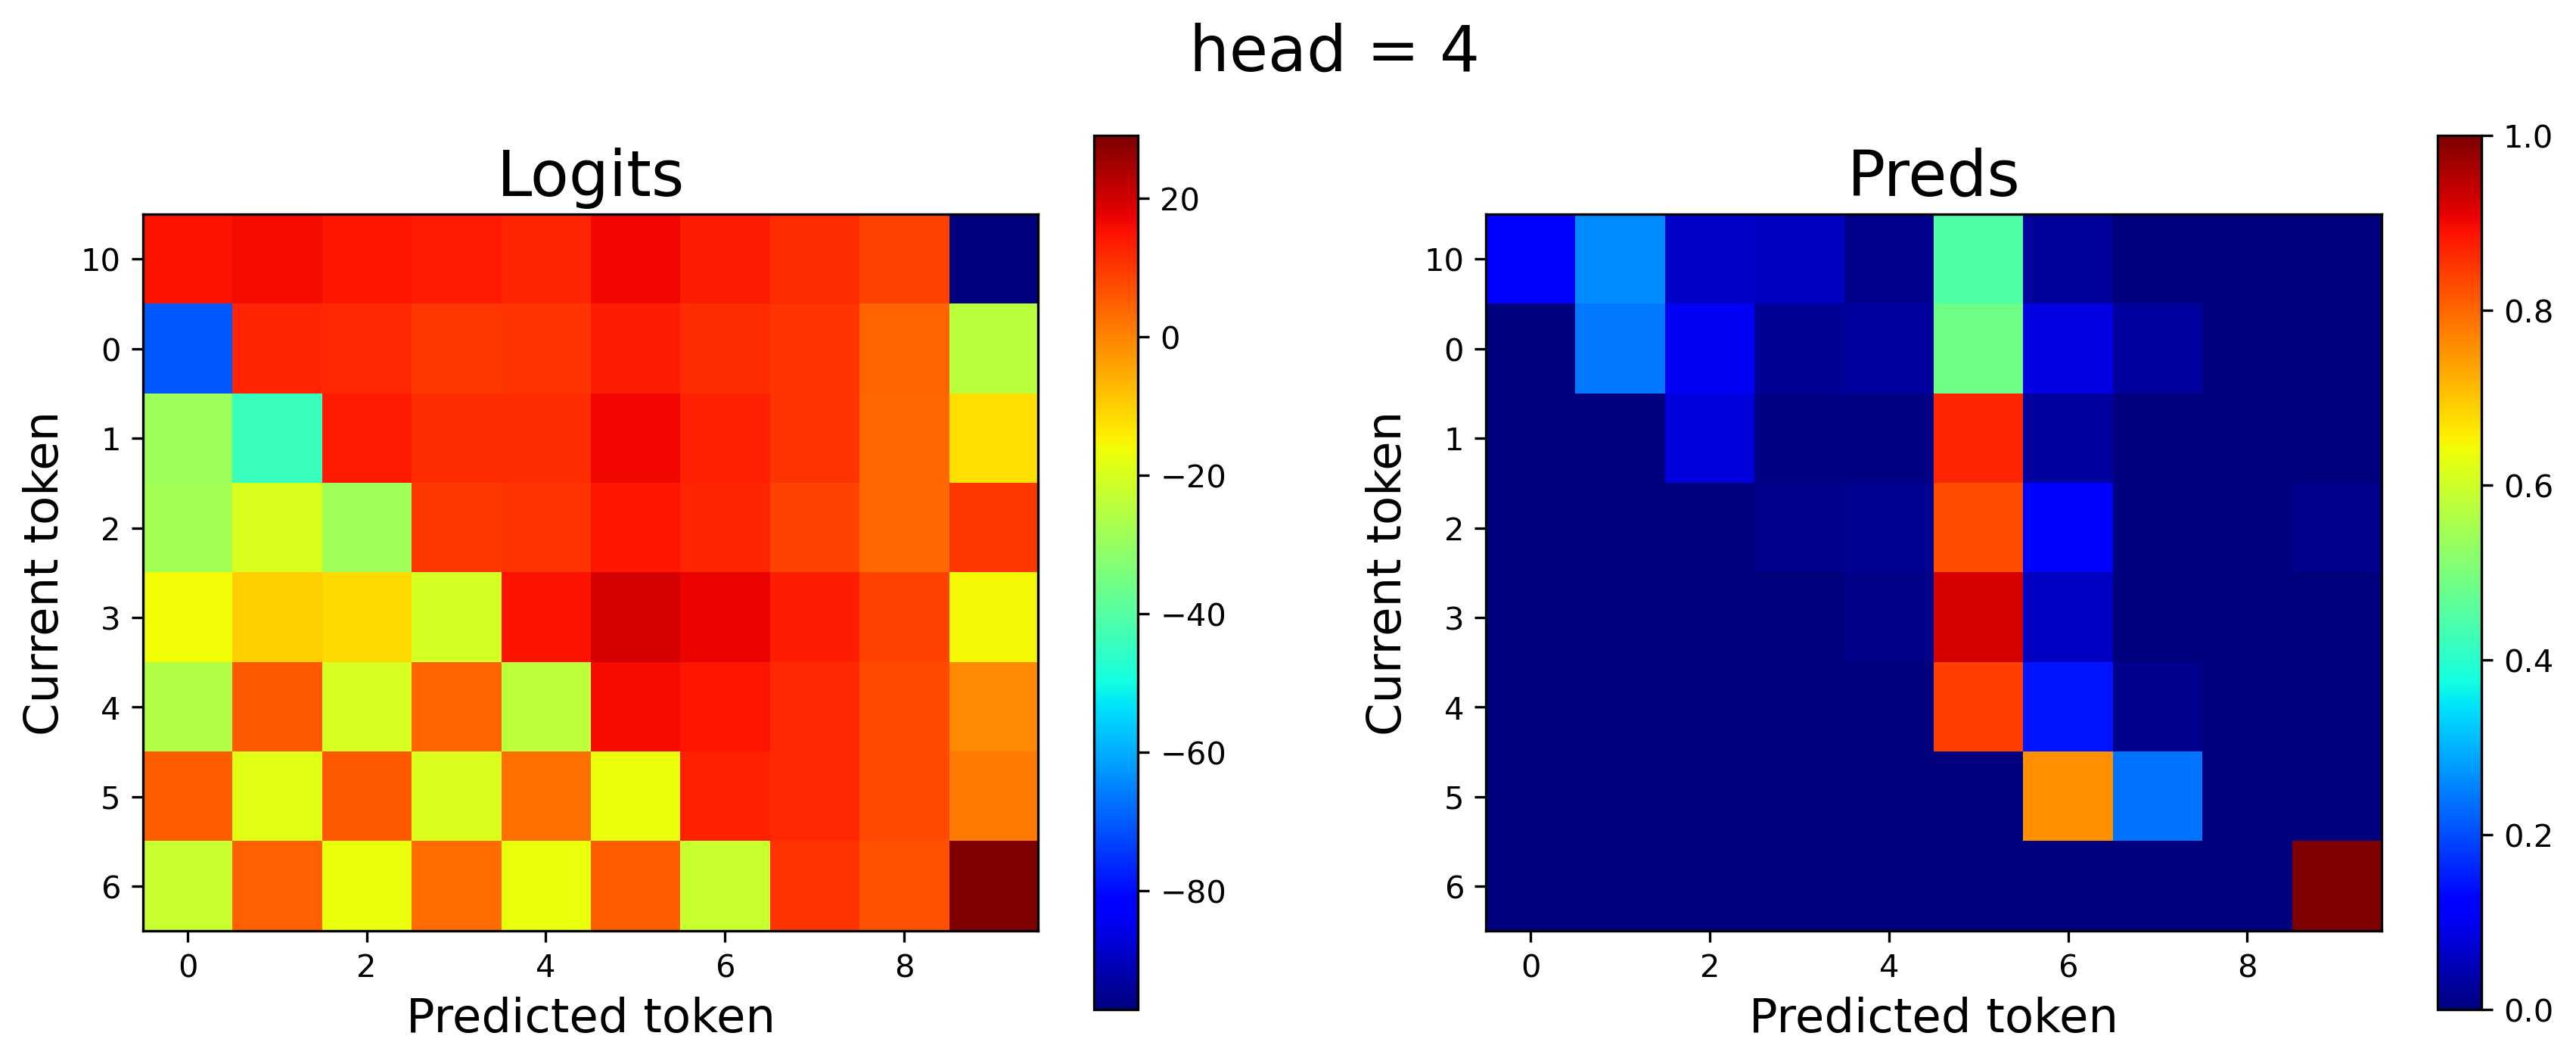

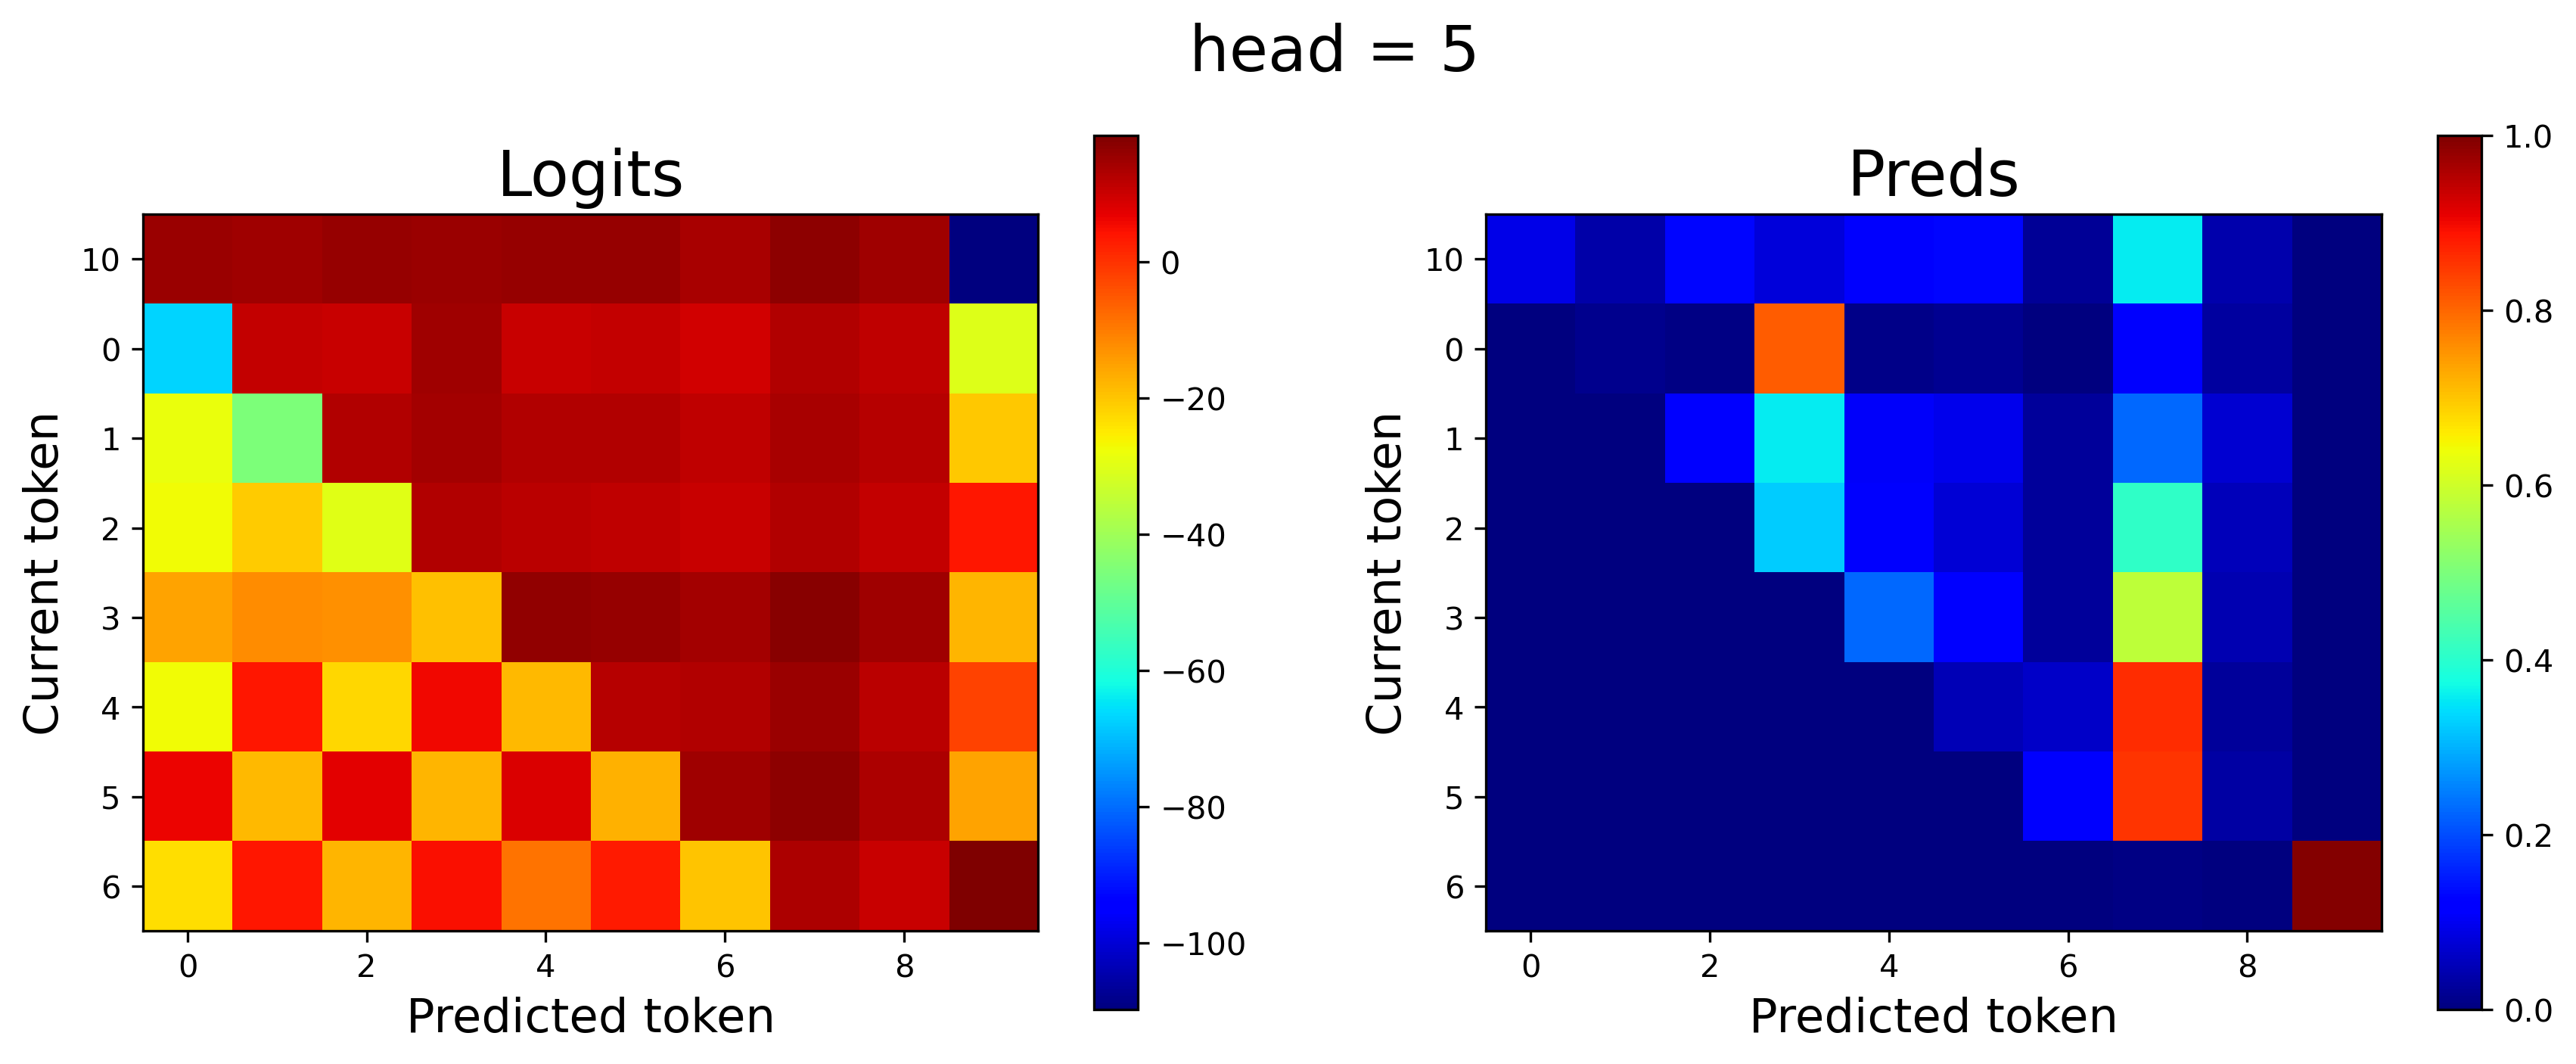

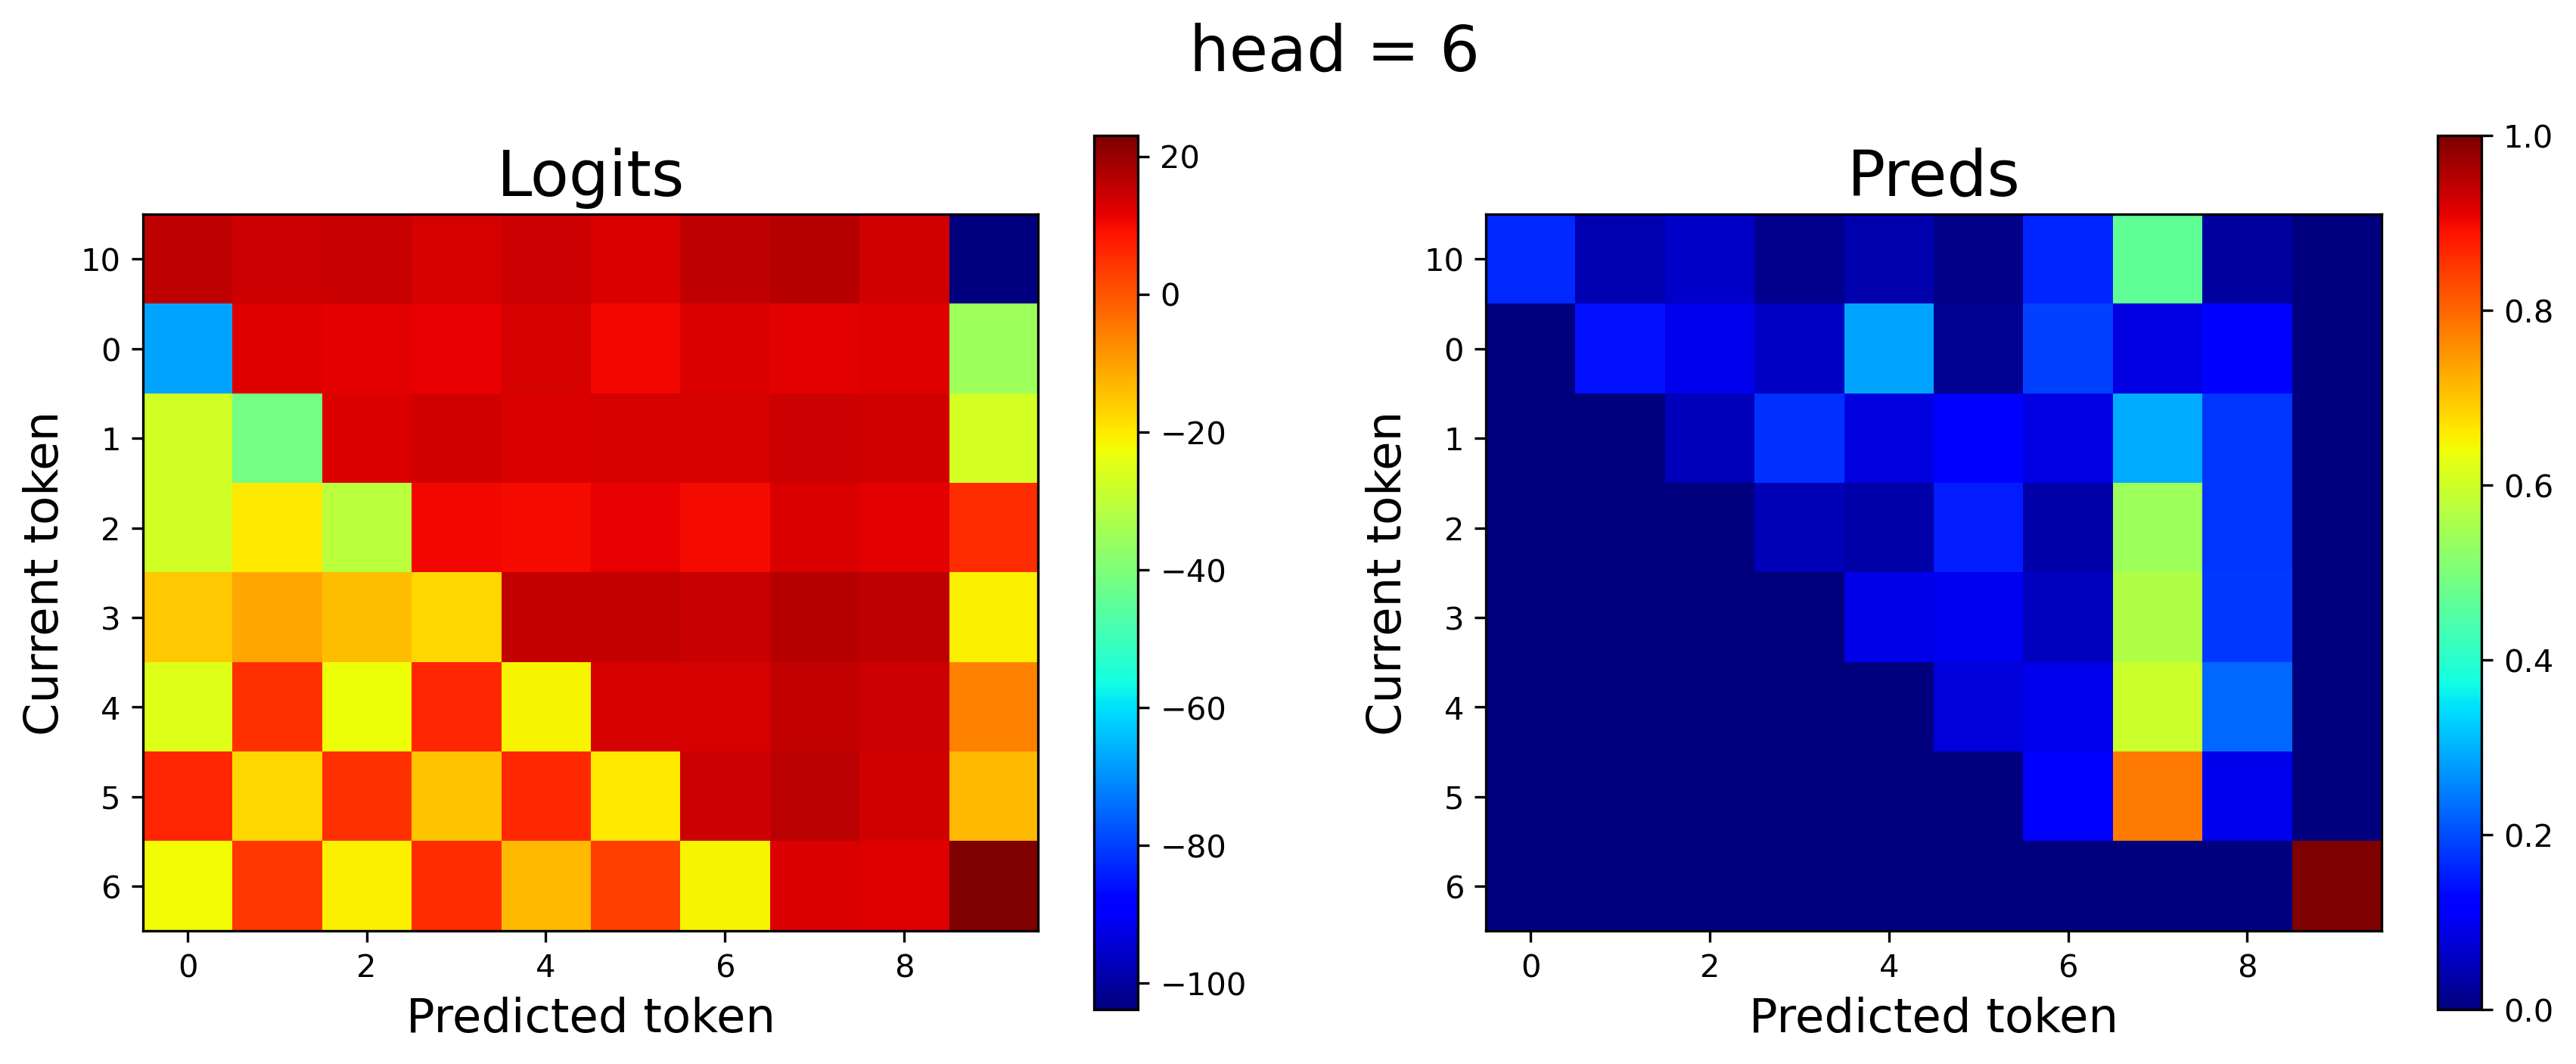

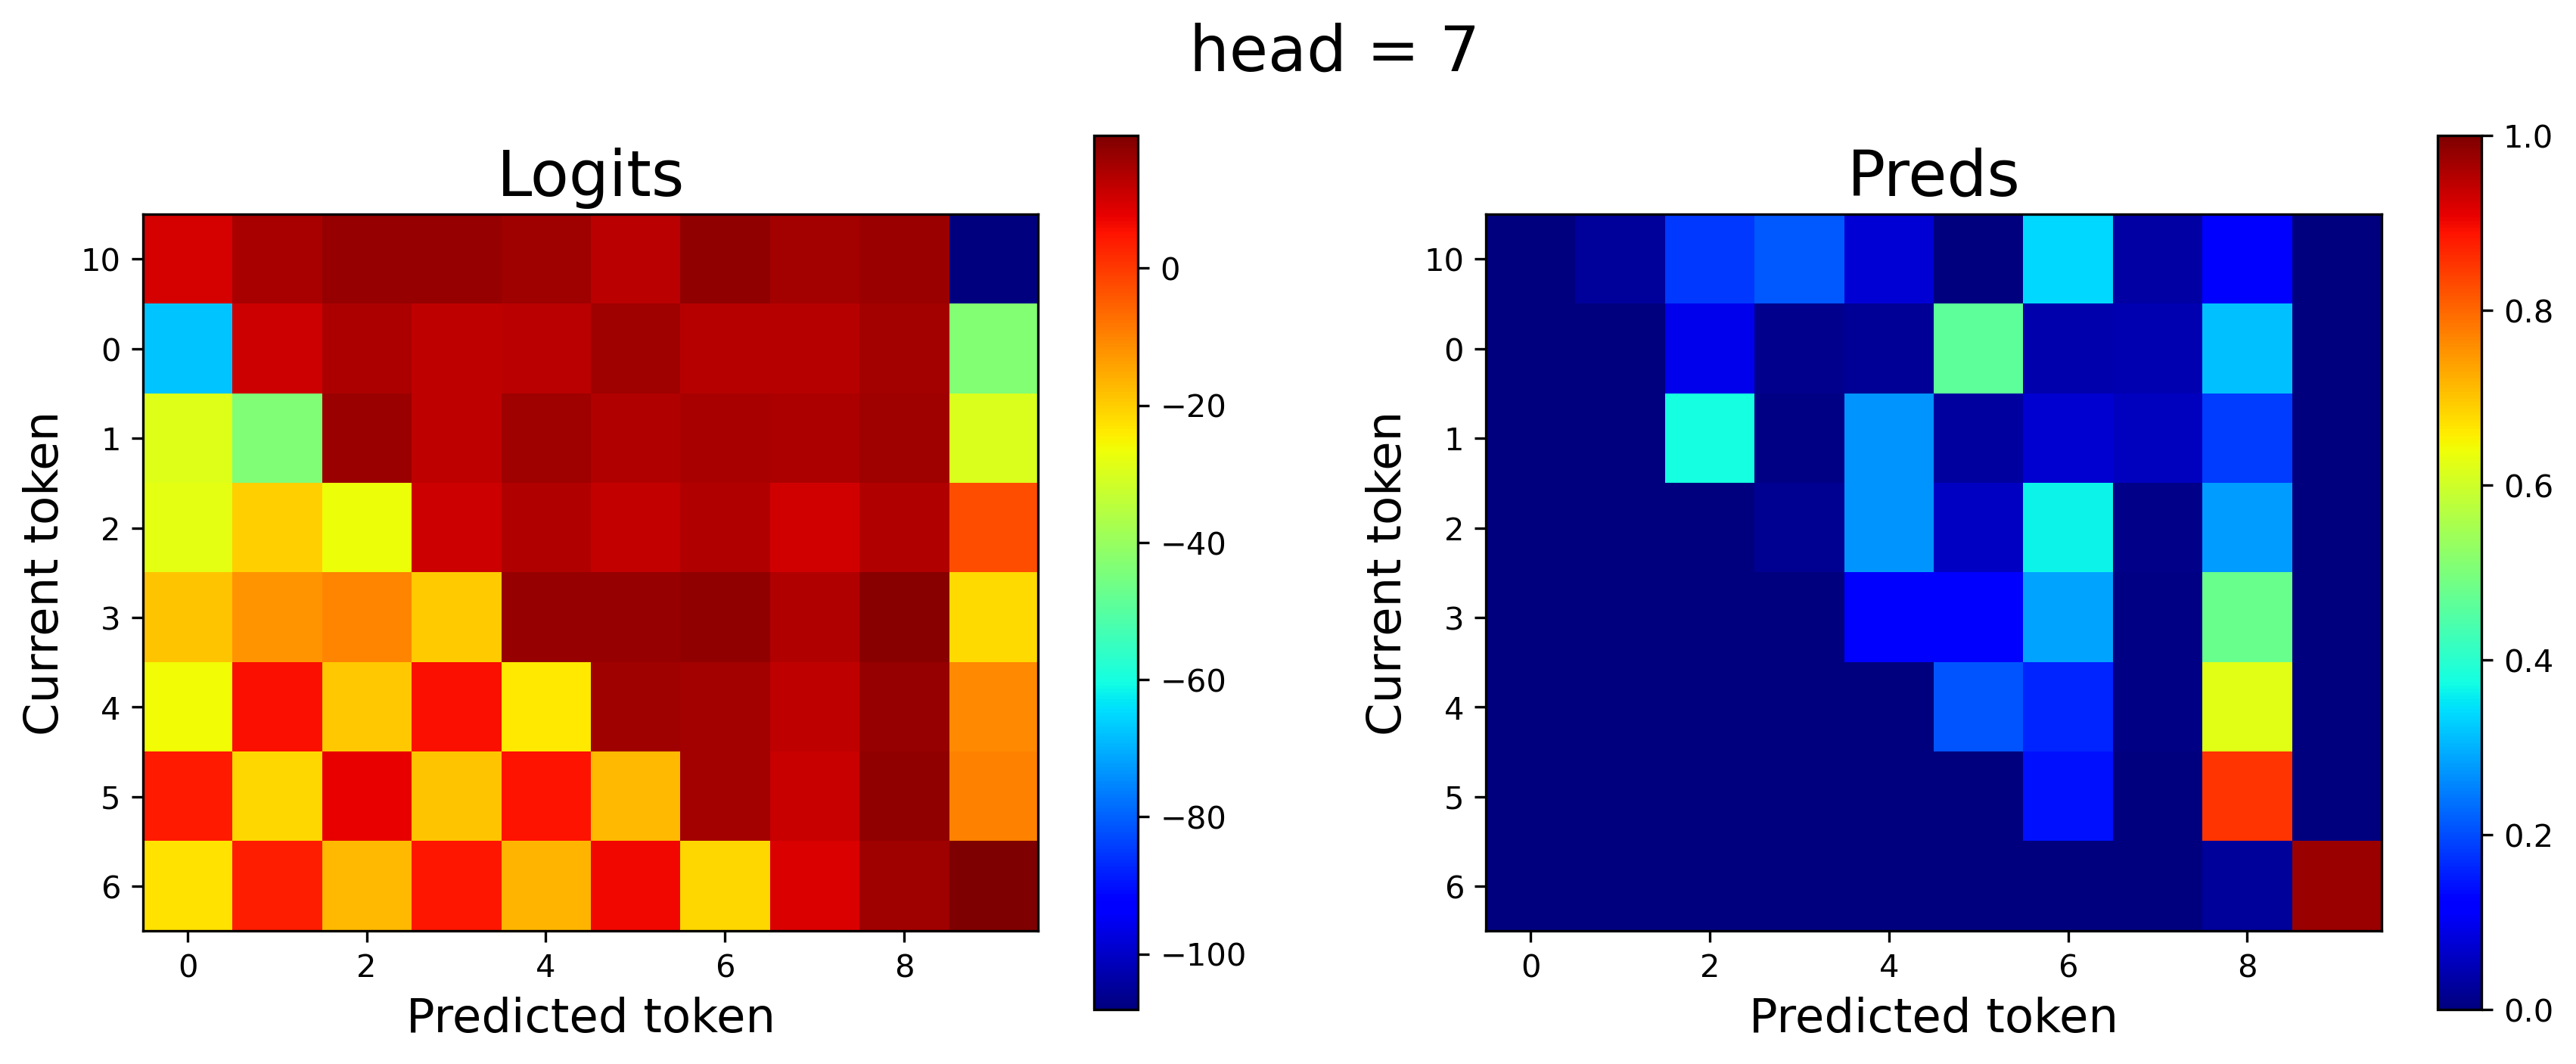

In [137]:
for i in range(8):
    interpretability.plot_predictions(
        example_game,
        interpretability.ablate_one_head(model, i, example_game),
        suptitle=f"head = {i}",
    )

### Testing the Head 2 Hypothesis

At this point we think that head 2 is responsible for end-game calculations. But we've only tried it on one game. Let's see if it generalizes across our entire dataset

### Setting up the experiment, feel free to ignore

In [142]:
df = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")

/tmp/ipykernel_4508/4071489902.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')


In [151]:
def head_ablated_loss(data, head, model):
    data_size = data.shape[0]
    target = einops.repeat(
        torch.tensor([0.0] * 9 + [1.0]),
        "logit_dim -> data_size logit_dim",
        data_size=data_size,
    ).to("cuda")
    logits = interpretability.ablate_one_head(model, head, data)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target, reduction="none")
    loss.to("cpu").detach().numpy()
    return loss

In [172]:
# long run time
batch_restarts = (
    [0]
    + [df.loc[df["steps till end state"] == i].index[0] for i in [6, 7, 8, 9]]
    + [len(df)]
)
heads = list(range(8))
batch_size = 4096
df_ablation_losses = pd.DataFrame(columns=["moves played"] + heads)
with torch.no_grad():
    for head in tqdm.tqdm(heads):
        head_losses = []
        for j in tqdm.tqdm(range(len(batch_restarts) - 1)):
            batch_size = min(batch_restarts[j + 1], batch_size)
            for i in range(batch_restarts[j], batch_restarts[j + 1], batch_size):
                batch_gap = batch_restarts[j + 1] - i
                batch_size = batch_gap if batch_gap < batch_size else batch_size
                games = torch.stack(
                    [
                        torch.tensor([10] + eval(game))
                        for game in df["moves played"].iloc[i : i + batch_size]
                    ]
                ).to("cuda")
                loss = head_ablated_loss(games, head, model)
                head_losses.append(loss)
        inter = [
            loss.item()
            for loss in torch.cat(
                [torch.flatten(batch_losses) for batch_losses in head_losses]
            )
        ]

        df_ablation_losses[head] = inter

  0%|          | 0/5 [00:00<?, ?it/s]

/home/thetis/Code/Tic-Tac-Transformer/alphatoe/interpretability.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(seq))
100%|██████████| 8/8 [00:35<00:00,  4.49s/it]


In [174]:
df_ablation_losses["first win condition"] = df["first win condition"]
plottable_ablation_losses = df_ablation_losses[
    df_ablation_losses["first win condition"].notna()
]
plottable_ablation_losses = plottable_ablation_losses.drop(columns=["moves played"])

### Plotting Average Loss Increase by Head Ablation

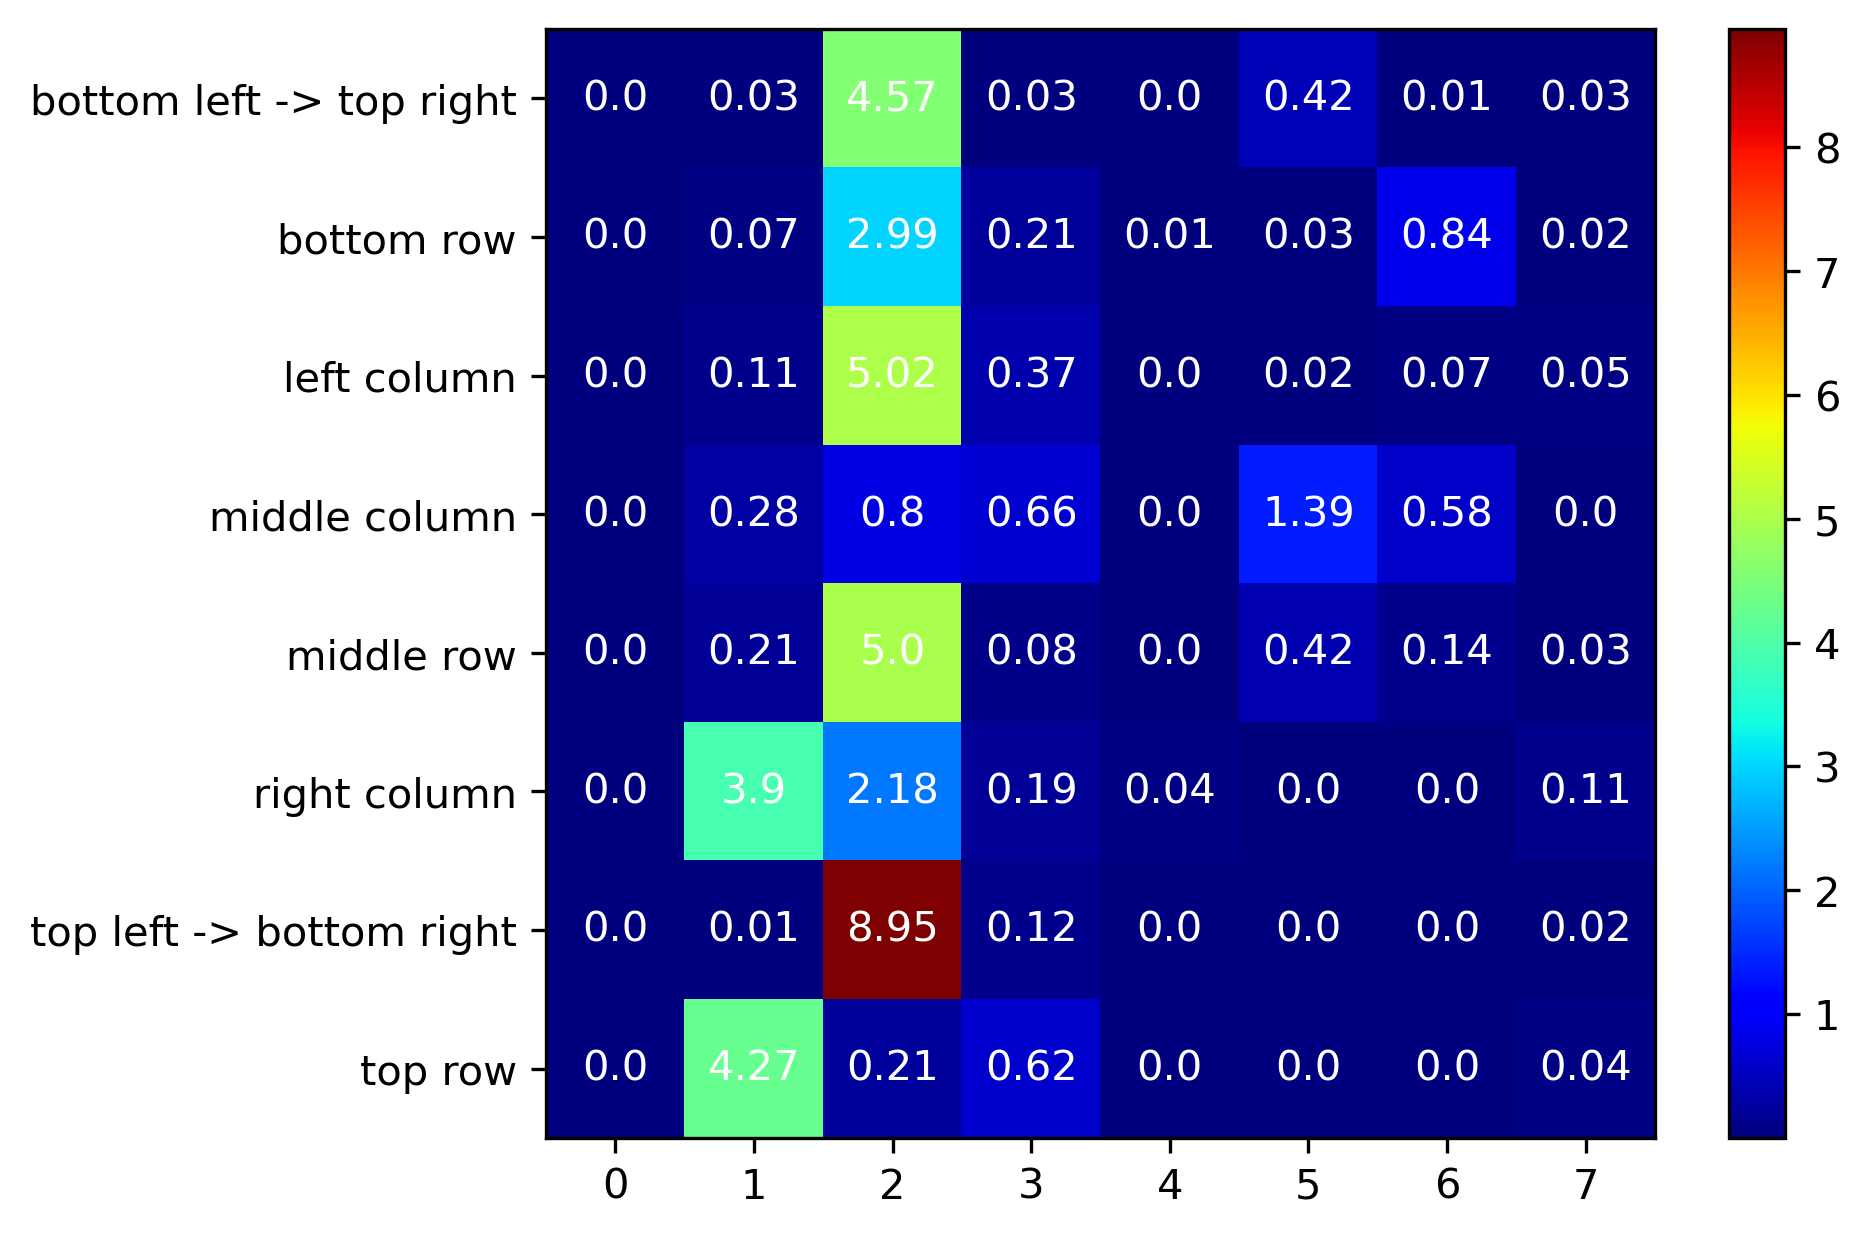

In [180]:
grouped = plottable_ablation_losses.groupby(["first win condition"])
plt.imshow(grouped.mean(), cmap="jet", interpolation="nearest")
plt.colorbar()
# legend
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], labels=grouped.mean().columns)
# yticks
plt.yticks(np.arange(0, 8), labels=grouped.mean().index)
# dpi
plt.rcParams["figure.dpi"] = 150

for i in range(0, 8):
    for j in range(0, 8):
        plt.text(
            j,
            i,
            grouped.mean().iloc[i, j].round(2),
            ha="center",
            va="center",
            color="w",
        )

The x axis is the head, and the y axis is which kind of game over the head is calculating. For instance, middle column could mean X's or O's straight down the middle column

In [183]:
# For example
game.play_game([1, 2, 4, 5, 7])

|   | X | O |
|   | X | O |
|   | X |   |


The hypothesis was mostly correct. Attention head 2 does the bulk of the work when it comes to identifying game-overs. The question becomes, how do we understand what head 2 is doing?

One possibility is to take a deeper look at the attention patterns of head 2. But we can do better: Since our dictionary size and sequence lengths are so small, we can take the QK matrix for head 2, and multiply it by the embedding on both sides. This will give us the exact patterns that head 2 associates between tokens. We can do the same thing with the positional embedding to see how token positions influence attention as well! 

### Setting up QK matrices feel free to skip

In [193]:
pos_emb = model.pos_embed(torch.zeros(1, 10, 128), 0)[0]
QK = einops.einsum(
    model.blocks[0].attn.W_Q,
    model.blocks[0].attn.W_K,
    "h_ind r_dim h_dim, h_ind r_dim2 h_dim -> h_ind r_dim r_dim2",
)
QK_circuit = einops.einsum(
    model.W_E,
    QK,
    model.W_E,
    "dict_size1 r_dim1, h_ind r_dim1 r_dim2, dict_size2 r_dim2 -> h_ind dict_size1 dict_size2",
)

QK_circuit_pos = torch.tril(
    einops.einsum(
        pos_emb,
        QK,
        pos_emb,
        "dict_size1 r_dim1, h_ind r_dim1 r_dim2, dict_size2 r_dim2 -> h_ind dict_size1 dict_size2",
    )
)

QK_circuit_pos_emb = einops.einsum(
    pos_emb,
    QK,
    model.W_E,
    "dict_size1 r_dim1, h_ind r_dim1 r_dim2, dict_size2 r_dim2 -> h_ind dict_size1 dict_size2",
)
QK_circuit_emb_pos = einops.einsum(
    model.W_E,
    QK,
    pos_emb,
    "dict_size1 r_dim1, h_ind r_dim1 r_dim2, dict_size2 r_dim2 -> h_ind dict_size1 dict_size2",
)

In [192]:
model.W_pos.shape

torch.Size([10, 128])

In [ ]:
The

### The QK circuit for head 2

In [199]:
i = 2
# plot.imshow_div(QK_circuit[i], show=True, yaxis="Q", xaxis="K", zmax=zmax, zmin=zmin)
# plot.imshow_div(QK_circuit_pos[i], show=True,yaxis="Q pos", xaxis="K pos", zmax=zmax, zmin=zmin)
# plot.imshow_div(QK_circuit_pos_emb[i], show=True,yaxis="Q pos", xaxis="K", zmax=zmax, zmin=zmin)
# plot.imshow_div(QK_circuit_emb_pos[i], show=True,yaxis="Q", xaxis="K pos", zmax=zmax, zmin=zmin)
plot.imshow_div(QK_circuit[i], yaxis="Q", xaxis="K", title="token -> token influence")
plot.imshow_div(
    QK_circuit_pos[i],
    yaxis="Q pos",
    xaxis="K pos",
    title="position -> position influence",
)
plot.imshow_div(
    QK_circuit_pos_emb[i], yaxis="Q pos", xaxis="K", title="position -> token influence"
)
plot.imshow_div(
    QK_circuit_emb_pos[i], yaxis="Q", xaxis="K pos", title="token -> position influence"
)

These four plots should completely describe how the attention head relates the tokens and the positional embeddings.

We haven't managed to understand what this head is doing yet, but it's a unique feature of our model because of the small dictionary size.